In [11]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import scipy
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import PIL 
import PIL.Image

In [14]:
print (tf.__version__)

2.10.0


In [15]:
# Set allow_growth to True
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
random.seed(404)


In [17]:
images_dir = './Images'

#### Rename des dossiers

In [18]:
# for old_dirname in os.listdir(images_dir):
#     # Extract the breed name from the directory name
#     breed_name = old_dirname.split('-')[-1]

#     # Construct the new directory name
#     new_dirname = breed_name

#     # Rename the directory, ignoring directories that already exist
#     try:
#         os.rename(os.path.join(images_dir, old_dirname), os.path.join(images_dir, new_dirname))
#     except FileExistsError:
#         pass


#### Rapide exploration

In [19]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 120


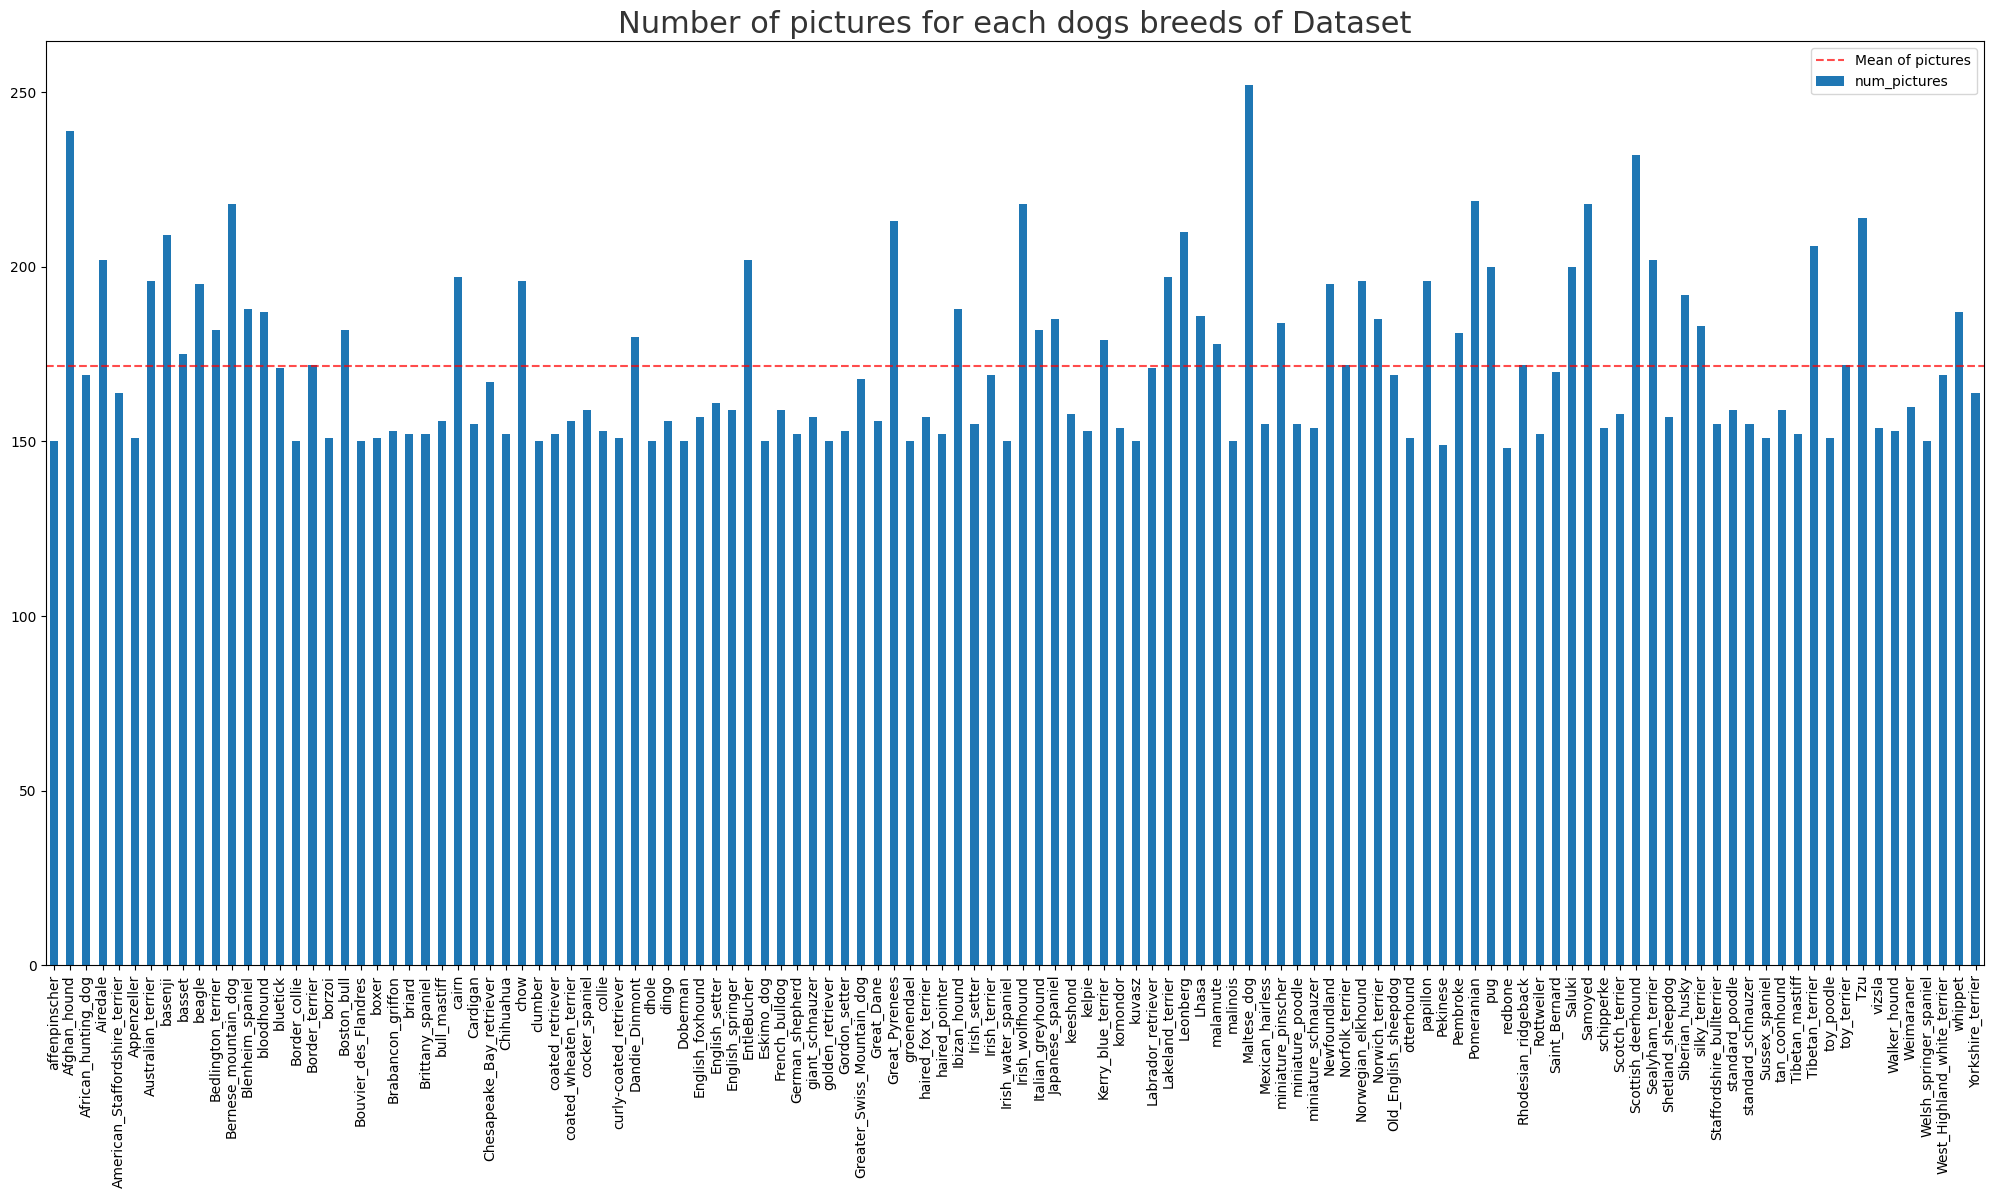

In [20]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=breed_list,
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

## Loading datas

### 10% des données

In [21]:
#Sélection de 12 races de chien au hasard
random_breeds = random.sample(breed_list, 12)
random_breeds

['Bernese_mountain_dog',
 'Yorkshire_terrier',
 'Great_Dane',
 'Walker_hound',
 'affenpinscher',
 'komondor',
 'Pembroke',
 'miniature_pinscher',
 'Blenheim_spaniel',
 'English_springer',
 'borzoi',
 'Greater_Swiss_Mountain_dog']

In [22]:
for breeds in random_breeds:
    train_dir = f"train/{breeds}"
    val_dir = f"val/{breeds}"
    test_dir = f"test/{breeds}"

    [os.makedirs(path) for path in [train_dir,val_dir,test_dir] if os.path.isdir(path) is False]

In [23]:
# for breeds in random_breeds:
#     path_train = f"./train/{breeds}"
#     path_valid = f"./val/{breeds}"
#     path_test = f"./test/{breeds}"
    

#     if len(os.listdir(path_train)+os.listdir(path_valid)+os.listdir(path_test)) == 0:

#         list_path_images = os.listdir(path=f"./Images/{breeds}")
        
    
#         for path_image in random.sample(list_path_images, int(len(os.listdir(f"./Images/{breeds}"))*0.75)):
#             shutil.copy(f"./Images/{breeds}/{path_image}", path_train)
#             list_path_images.remove(path_image)

#         for path_image in random.sample(list_path_images, int(len(os.listdir(f"./Images/{breeds}"))*0.15)):
#             shutil.copy(f"./Images/{breeds}/{path_image}", path_valid)
#             list_path_images.remove(path_image)

#         for path_image in random.sample(list_path_images, int(len(os.listdir(f"./Images/{breeds}"))*0.10)):
#             shutil.copy(f"./Images/{breeds}/{path_image}", path_test)
#             list_path_images.remove(path_image)
#     else:
#         print("Les dossiers ne sont pas vides")
#         break

#### Data sans filtre RGB

In [23]:
print("train data :")
train_image_data_generator = ImageDataGenerator(rescale=1./255,
                                                rotation_range=40,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True)
train_10 = train_image_data_generator.flow_from_directory(directory="./train",
                                                               target_size=(224,224),
                                                               classes=random_breeds,
                                                               batch_size=32)

print("val data :")
val_image_data_generator = ImageDataGenerator(rescale=1./255)
val_10 = val_image_data_generator.flow_from_directory(directory="./val",
                                                               target_size=(224,224),
                                                               classes=random_breeds,
                                                               batch_size=32)


print("test data :")
test_image_data_generator = ImageDataGenerator(rescale=1./255)
test_10 = test_image_data_generator.flow_from_directory(directory="./test",
                                                             target_size=(224,224),
                                                             classes=random_breeds,
                                                             batch_size=32,
                                                             shuffle=False)

train data :
Found 1516 images belonging to 12 classes.
val data :
Found 298 images belonging to 12 classes.
test data :
Found 197 images belonging to 12 classes.


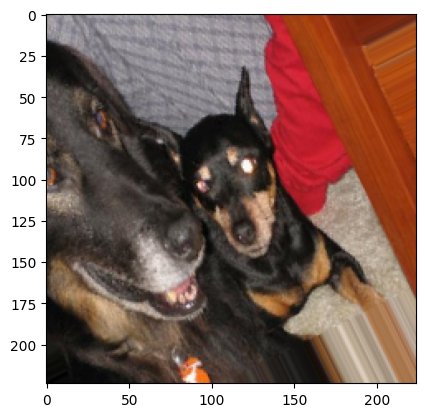

In [24]:
# Get a batch of images and labels
batch_images, batch_labels = next(train_10)

# Select a random image from the batch
random_index = np.random.randint(0, 10)
random_image = batch_images[random_index]

# Display the image
plt.imshow(random_image)
plt.show()

#### Data avec filtre RGB

In [25]:
print("train data :")
train_image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                                rotation_range=40,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True)
train_10_rgb = train_image_data_generator.flow_from_directory(directory="./train",
                                                               target_size=(224,224),
                                                               classes=random_breeds,
                                                               batch_size=32)

print("val data :")
val_image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,)
val_10_rgb = val_image_data_generator.flow_from_directory(directory="./val",
                                                               target_size=(224,224),
                                                               classes=random_breeds,
                                                               batch_size=32)


print("test data :")
test_image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,)
test_10_rgb = test_image_data_generator.flow_from_directory(directory="./test",
                                                             target_size=(224,224),
                                                             classes=random_breeds,
                                                             batch_size=32,
                                                             shuffle=False)

train data :
Found 1516 images belonging to 12 classes.
val data :
Found 298 images belonging to 12 classes.
test data :
Found 197 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


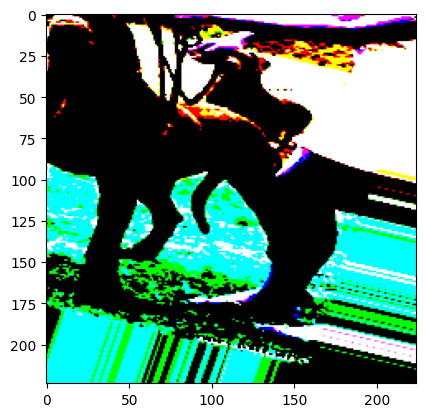

In [26]:
# Get a batch of images and labels
batch_images, batch_labels = next(train_10_rgb)

# Select a random image from the batch
random_index = np.random.randint(0, 10)
random_image = batch_images[random_index]

# Display the image
plt.imshow(random_image)
plt.show()

### 100% des données

In [45]:
# from sklearn.model_selection import train_test_split

# # Define the ratio for splitting the dataset
# train_ratio = 0.75
# val_ratio = 0.15
# test_ratio = 0.1

# # Loop over the classes and split the dataset
# for class_name in breed_list:
#     class_dir = os.path.join(images_dir, class_name)
#     files = os.listdir(class_dir)
#     train_files, test_files = train_test_split(files, test_size=test_ratio)
#     train_files, val_files = train_test_split(train_files, test_size=val_ratio/(train_ratio+val_ratio))
    
#     # Create the directories for the training, validation, and test data
#     train_dir = os.path.join('./data/train', class_name)
#     val_dir = os.path.join('./data/val', class_name)
#     test_dir = os.path.join('./data/test', class_name)
#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)
    
#     # Move the files to the appropriate directories
#     for file in train_files:
#         src = os.path.join(class_dir, file)
#         dst = os.path.join(train_dir, file)
#         shutil.copy(src, dst)
        
#     for file in val_files:
#         src = os.path.join(class_dir, file)
#         dst = os.path.join(val_dir, file)
#         shutil.copy(src, dst)
        
#     for file in test_files:
#         src = os.path.join(class_dir, file)
#         dst = os.path.join(test_dir, file)
#         shutil.copy(src, dst)

#### Data sans filtre RGB

In [46]:
# Define the directories for the training, validation, and test data
train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

# Define the batch size
batch_size = 32

# Create the data generators for training, validation, and test data
print("train data :")
train_image_data_generator = ImageDataGenerator(rescale=1./255,
                                                rotation_range=40,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True)
train_100 = train_image_data_generator.flow_from_directory(directory=train_dir,
                                                               target_size=(224,224),
                                                               class_mode='categorical',
                                                               batch_size=batch_size)

print("val data :")
val_image_data_generator = ImageDataGenerator(rescale=1./255)
val_100 = val_image_data_generator.flow_from_directory(directory=val_dir,
                                                               target_size=(224,224),
                                                               class_mode='categorical',
                                                               batch_size=batch_size)


print("test data :")
test_image_data_generator = ImageDataGenerator(rescale=1./255)
test_100 = test_image_data_generator.flow_from_directory(directory=test_dir,
                                                             target_size=(224,224),
                                                             class_mode='categorical',
                                                             batch_size=batch_size,
                                                             shuffle=False)

train data :
Found 15338 images belonging to 120 classes.
val data :
Found 3131 images belonging to 120 classes.
test data :
Found 2110 images belonging to 120 classes.


#### Data avec filtre RGB

In [47]:
# Define the image dimensions
img_width, img_height = 224, 224

# Define the directories for the training, validation, and test data
train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

# Define the batch size
batch_size = 32

# Create the data generators for training, validation, and test data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_100_rgb = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    classes=breed_list)

val_100_rgb = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                classes=breed_list)

test_100_rgb = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  classes=breed_list)

Found 15338 images belonging to 120 classes.
Found 3131 images belonging to 120 classes.
Found 2110 images belonging to 120 classes.


## Baseline

### Dummy classifier

In [48]:
from sklearn.dummy import DummyClassifier

# Create a dummy classifier and fit it to the training data
dummy = DummyClassifier(strategy='uniform')
dummy.fit(train_10.next()[0], train_10.next()[1])

# Evaluate the dummy classifier on the test data
score = dummy.score(test_10.next()[0], test_10.next()[1])
print('Accuracy:', score)

Accuracy: 0.0


### SGD classifier

In [58]:
from sklearn.linear_model import SGDClassifier

In [60]:
# Initialize the SGD classifier
sgd = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1000)

# Train the SGD classifier
for images, labels in train_10:
    # Preprocess the images
    images = np.array(images)
    images = images.reshape(images.shape[0], -1)

    # Train the classifier
    sgd.partial_fit(images, np.argmax(labels, axis=1), classes=np.arange(10))
    
    # Break the loop when all training data has been seen
    if train_10.batch_index == 0:
        break

# Evaluate the performance of the classifier
valid_images, valid_labels = next(val_10)
valid_images = np.array(valid_images)
valid_images = valid_images.reshape(valid_images.shape[0], -1)
y_pred = sgd.predict(valid_images)
accuracy = np.mean(y_pred == np.argmax(valid_labels, axis=1))
print("Validation accuracy:", accuracy)

Validation accuracy: 0.28125


## CNN from scratch

### Train sur 10% des classes

In [14]:
# Set the parameters for the CNN model
num_classes = 12
input_shape = (224, 224, 3)

# Define the CNN architecture
model = keras.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Train the model
epochs = 50
history = model.fit(train_10, epochs=epochs, validation_data=val_10)

Epoch 1/50
49/49 [==============================] - 24s 354ms/step - loss: 4.1356 - accuracy: 0.0974 - val_loss: 2.4559 - val_accuracy: 0.1078
Epoch 2/50
49/49 [==============================] - 16s 325ms/step - loss: 2.4496 - accuracy: 0.1451 - val_loss: 2.3948 - val_accuracy: 0.1340
Epoch 3/50
49/49 [==============================] - 16s 319ms/step - loss: 2.4133 - accuracy: 0.1367 - val_loss: 2.3507 - val_accuracy: 0.1601
Epoch 4/50
49/49 [==============================] - 16s 316ms/step - loss: 2.3782 - accuracy: 0.1418 - val_loss: 2.3131 - val_accuracy: 0.1797
Epoch 5/50
49/49 [==============================] - 16s 327ms/step - loss: 2.3548 - accuracy: 0.1586 - val_loss: 2.3394 - val_accuracy: 0.1765
Epoch 6/50
49/49 [==============================] - 15s 311ms/step - loss: 2.3498 - accuracy: 0.1593 - val_loss: 2.2835 - val_accuracy: 0.2190
Epoch 7/50
49/49 [==============================] - 15s 310ms/step - loss: 2.3192 - accuracy: 0.1728 - val_loss: 2.2942 - val_accuracy: 0.2124

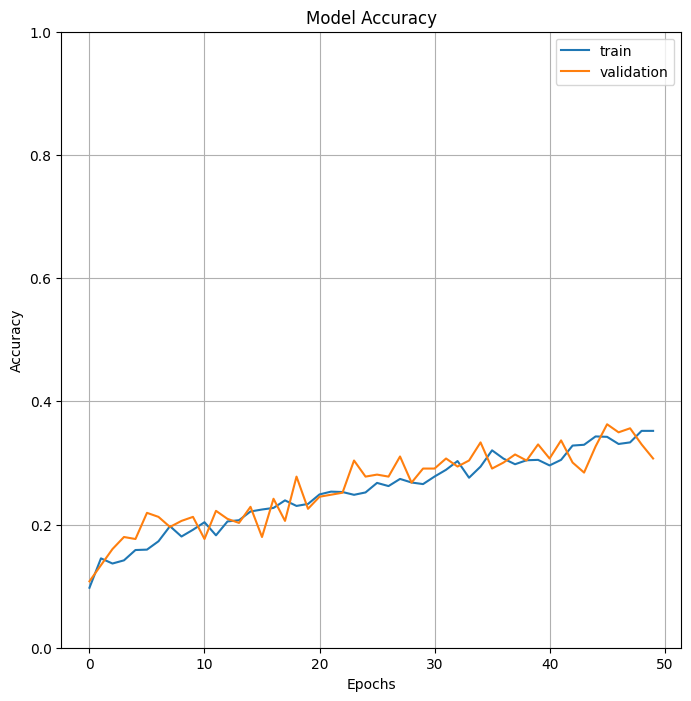

In [17]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

In [20]:
# Set the parameters for the CNN model
num_classes = 12
input_shape = (224, 224, 3)

# Define the CNN architecture
model = keras.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])

In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Train the model
epochs = 50
history = model.fit(train_10_rgb, epochs=epochs, validation_data=val_10_rgb)

Epoch 1/50
49/49 [==============================] - 16s 324ms/step - loss: 146.2877 - accuracy: 0.0941 - val_loss: 2.4834 - val_accuracy: 0.0948
Epoch 2/50
49/49 [==============================] - 16s 319ms/step - loss: 2.4828 - accuracy: 0.1012 - val_loss: 2.4814 - val_accuracy: 0.1078
Epoch 3/50
49/49 [==============================] - 16s 322ms/step - loss: 2.4807 - accuracy: 0.1025 - val_loss: 2.4794 - val_accuracy: 0.1046
Epoch 4/50
49/49 [==============================] - 16s 320ms/step - loss: 2.4800 - accuracy: 0.0993 - val_loss: 2.4781 - val_accuracy: 0.1013
Epoch 5/50
49/49 [==============================] - 16s 324ms/step - loss: 2.4781 - accuracy: 0.1077 - val_loss: 2.4773 - val_accuracy: 0.1046
Epoch 6/50
49/49 [==============================] - 16s 319ms/step - loss: 2.4779 - accuracy: 0.0954 - val_loss: 2.4765 - val_accuracy: 0.1013
Epoch 7/50
49/49 [==============================] - 16s 321ms/step - loss: 2.4772 - accuracy: 0.1032 - val_loss: 2.4761 - val_accuracy: 0.10

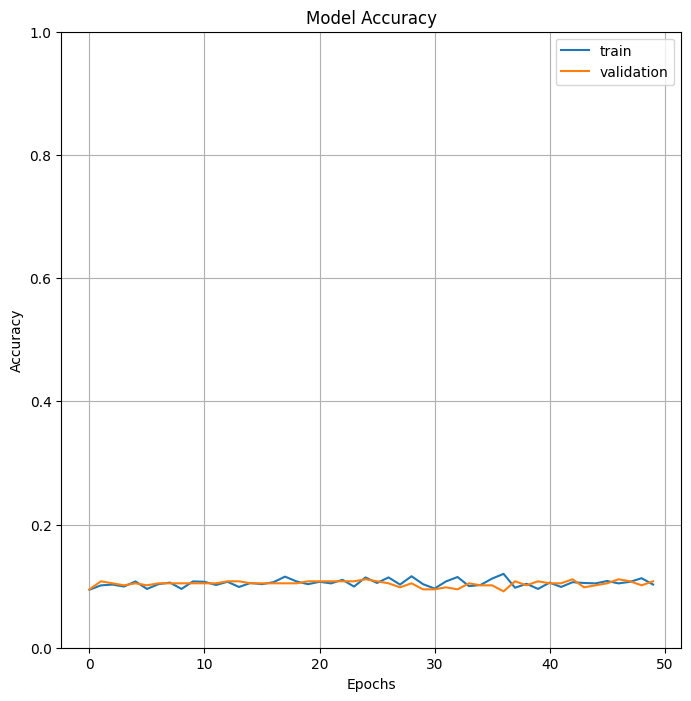

In [23]:
plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

### Train sur 100% des données

In [8]:
# Set the parameters for the CNN model
num_classes = 120
input_shape = (224, 224, 3)

# Define the CNN architecture
model = keras.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
epochs = 50
history = model.fit(train_100, epochs=epochs, validation_data=val_100)

Epoch 1/50
590/590 [==============================] - 220s 372ms/step - loss: 4.8927 - accuracy: 0.0096 - val_loss: 4.7559 - val_accuracy: 0.0181
Epoch 2/50
590/590 [==============================] - 159s 270ms/step - loss: 4.7135 - accuracy: 0.0169 - val_loss: 4.5888 - val_accuracy: 0.0249
Epoch 3/50
590/590 [==============================] - 159s 270ms/step - loss: 4.6527 - accuracy: 0.0196 - val_loss: 4.5658 - val_accuracy: 0.0238
Epoch 4/50
590/590 [==============================] - 161s 273ms/step - loss: 4.6241 - accuracy: 0.0203 - val_loss: 4.5273 - val_accuracy: 0.0276
Epoch 5/50
590/590 [==============================] - 159s 269ms/step - loss: 4.6092 - accuracy: 0.0234 - val_loss: 4.4999 - val_accuracy: 0.0345
Epoch 6/50
590/590 [==============================] - 158s 268ms/step - loss: 4.5856 - accuracy: 0.0240 - val_loss: 4.4714 - val_accuracy: 0.0390
Epoch 7/50
590/590 [==============================] - 159s 269ms/step - loss: 4.5674 - accuracy: 0.0264 - val_loss: 4.4115 -

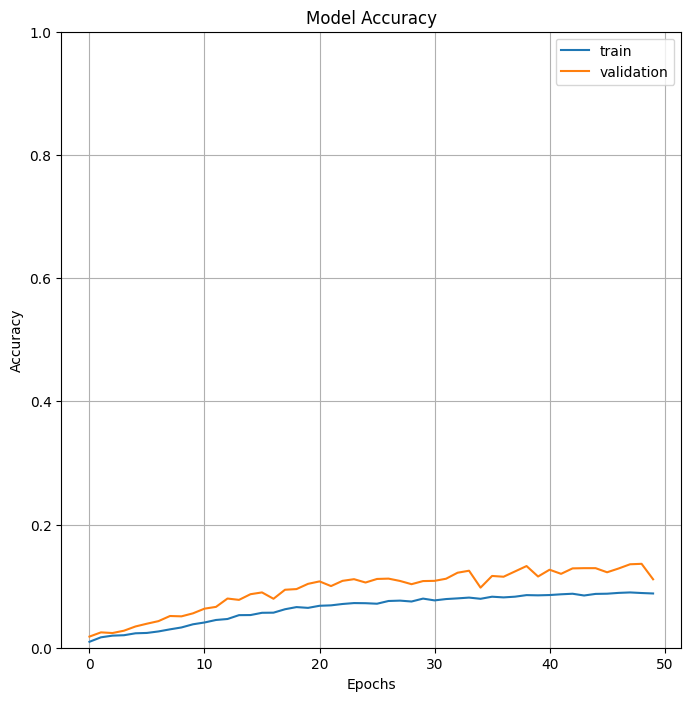

In [14]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

# CNN transfert learning

### Train sur 10% des données

In [ ]:
from tensorflow.keras.models import Sequential

resnet = Sequential()

transfert_resnet = tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(224,224,3),

                   pooling='avg',classes=12,

                   weights='imagenet')

for each_layer in transfert_resnet.layers:

        each_layer.trainable=False

resnet.add(transfert_resnet)

In [ ]:
resnet.add(Flatten())

resnet.add(Dense(512, activation='relu'))

resnet.add(Dense(12, activation='softmax'))

In [ ]:
resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
epochs = 50
history = resnet.fit(train_10, validation_data=val_10, epochs=epochs)

Epoch 1/50
49/49 [==============================] - 26s 462ms/step - loss: 2.5763 - accuracy: 0.0980 - val_loss: 2.5292 - val_accuracy: 0.1242
Epoch 2/50
49/49 [==============================] - 16s 326ms/step - loss: 2.4958 - accuracy: 0.1070 - val_loss: 2.4256 - val_accuracy: 0.1569
Epoch 3/50
49/49 [==============================] - 16s 322ms/step - loss: 2.4604 - accuracy: 0.1244 - val_loss: 2.4446 - val_accuracy: 0.1209
Epoch 4/50
49/49 [==============================] - 16s 324ms/step - loss: 2.4441 - accuracy: 0.1373 - val_loss: 2.4440 - val_accuracy: 0.1438
Epoch 5/50
49/49 [==============================] - 16s 323ms/step - loss: 2.4354 - accuracy: 0.1425 - val_loss: 2.3917 - val_accuracy: 0.1373
Epoch 6/50
49/49 [==============================] - 16s 323ms/step - loss: 2.4128 - accuracy: 0.1451 - val_loss: 2.3537 - val_accuracy: 0.1601
Epoch 7/50
49/49 [==============================] - 16s 322ms/step - loss: 2.4097 - accuracy: 0.1406 - val_loss: 2.3790 - val_accuracy: 0.1176

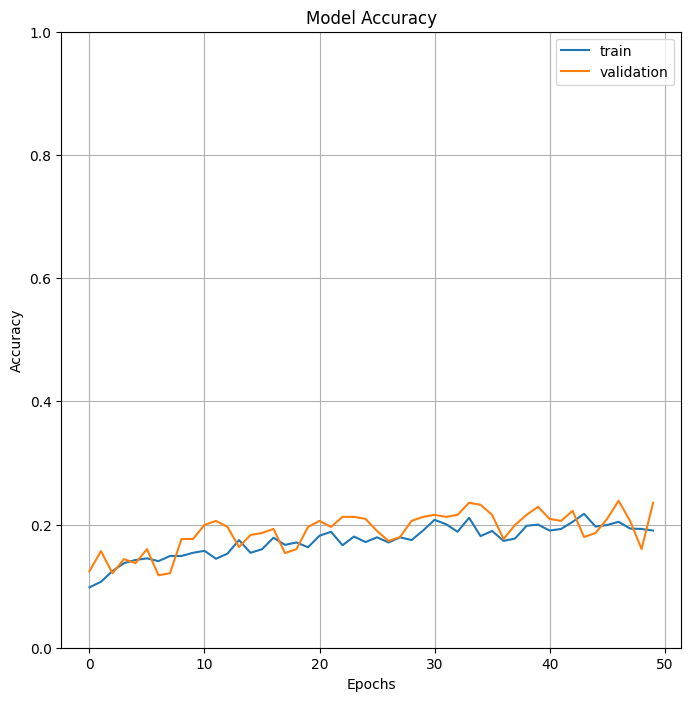

In [ ]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

In [ ]:
from tensorflow.keras.models import Sequential

resnet = Sequential()

transfert_resnet = tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(224,224,3),

                   pooling='avg',classes=12,

                   weights='imagenet')

for each_layer in transfert_resnet.layers:

        each_layer.trainable=False

resnet.add(transfert_resnet)

In [ ]:
resnet.add(Flatten())

resnet.add(Dense(512, activation='relu'))

resnet.add(Dense(12, activation='softmax'))

In [ ]:
resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
epochs = 50
history = resnet.fit(train_10_rgb, validation_data=val_10_rgb, epochs=epochs)

Epoch 1/50
49/49 [==============================] - 20s 344ms/step - loss: 0.6956 - accuracy: 0.7930 - val_loss: 0.1979 - val_accuracy: 0.9346
Epoch 2/50
49/49 [==============================] - 16s 325ms/step - loss: 0.2519 - accuracy: 0.9213 - val_loss: 0.1710 - val_accuracy: 0.9346
Epoch 3/50
49/49 [==============================] - 16s 327ms/step - loss: 0.1673 - accuracy: 0.9510 - val_loss: 0.2033 - val_accuracy: 0.9248
Epoch 4/50
49/49 [==============================] - 16s 326ms/step - loss: 0.1439 - accuracy: 0.9471 - val_loss: 0.2668 - val_accuracy: 0.9248
Epoch 5/50
49/49 [==============================] - 16s 327ms/step - loss: 0.1583 - accuracy: 0.9478 - val_loss: 0.1733 - val_accuracy: 0.9510
Epoch 6/50
49/49 [==============================] - 17s 351ms/step - loss: 0.0785 - accuracy: 0.9742 - val_loss: 0.1607 - val_accuracy: 0.9542
Epoch 7/50
49/49 [==============================] - 18s 374ms/step - loss: 0.0912 - accuracy: 0.9665 - val_loss: 0.1620 - val_accuracy: 0.9510

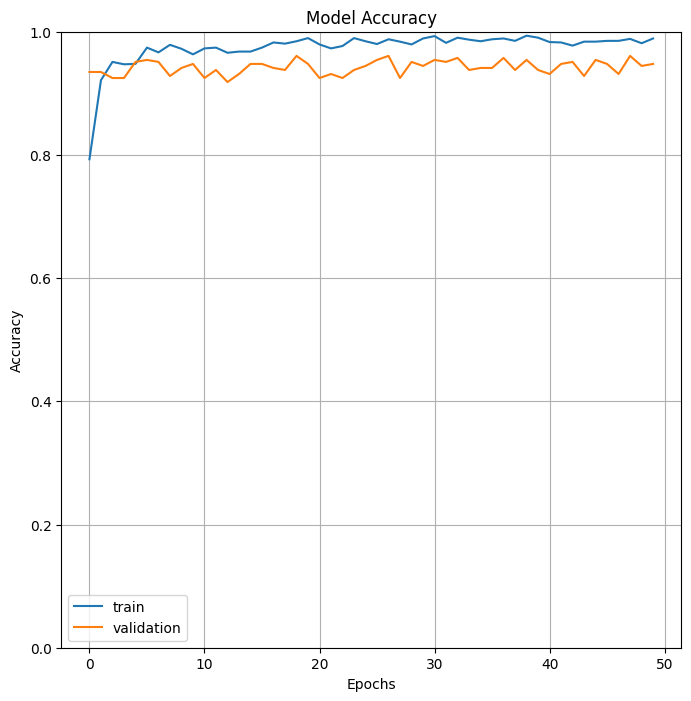

In [ ]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

### Train sur 100% des données

In [10]:
from tensorflow.keras.models import Sequential

resnet = Sequential()

transfert_resnet = tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(224,224,3),

                   pooling='avg',classes=120,

                   weights='imagenet')

for each_layer in transfert_resnet.layers:

        each_layer.trainable=False

resnet.add(transfert_resnet)

In [9]:
resnet.add(Flatten())

resnet.add(Dense(512, activation='relu'))

resnet.add(Dense(120, activation='softmax'))

In [10]:
resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
epochs = 50
history = resnet.fit(train_100_rgb, validation_data=val_100_rgb, epochs=epochs)

Epoch 1/50
480/480 [==============================] - 301s 609ms/step - loss: 1.9265 - accuracy: 0.4998 - val_loss: 0.9102 - val_accuracy: 0.7189
Epoch 2/50
480/480 [==============================] - 326s 681ms/step - loss: 1.1319 - accuracy: 0.6600 - val_loss: 0.8297 - val_accuracy: 0.7480
Epoch 3/50
480/480 [==============================] - 375s 780ms/step - loss: 1.0053 - accuracy: 0.6940 - val_loss: 0.8482 - val_accuracy: 0.7525
Epoch 4/50
480/480 [==============================] - 499s 1s/step - loss: 0.9198 - accuracy: 0.7206 - val_loss: 0.8726 - val_accuracy: 0.7522
Epoch 5/50
480/480 [==============================] - 326s 680ms/step - loss: 0.8579 - accuracy: 0.7315 - val_loss: 0.9094 - val_accuracy: 0.7311
Epoch 6/50
480/480 [==============================] - 686s 1s/step - loss: 0.7963 - accuracy: 0.7519 - val_loss: 0.9221 - val_accuracy: 0.7458
Epoch 7/50
480/480 [==============================] - 306s 638ms/step - loss: 0.7777 - accuracy: 0.7579 - val_loss: 0.8910 - val_a

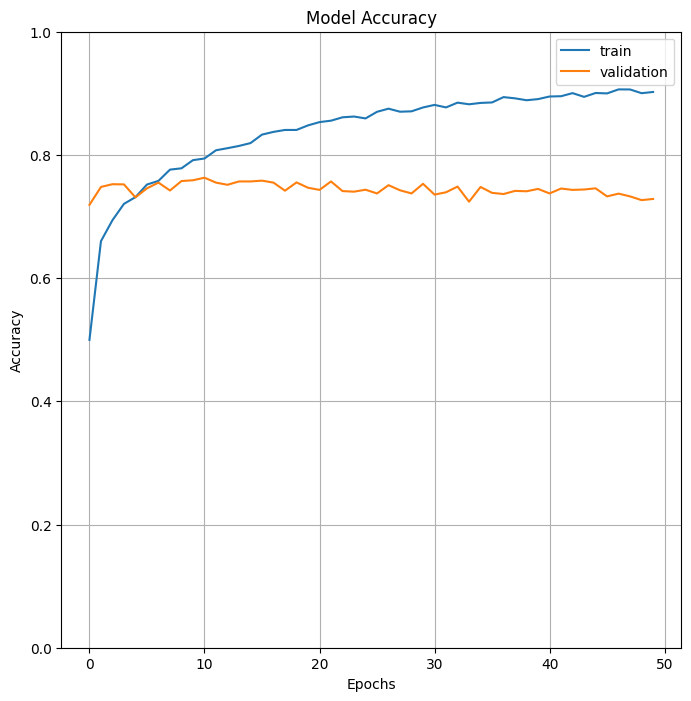

In [15]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(8, 8))
epochs_range= range(epochs)
plotter_lib.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plotter_lib.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plotter_lib.axis(ymin=0,ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])
#If you are using Windows or Linux Desktop please uncomment following line. This will not work on command line/terminal based OS 
plotter_lib.show()

In [16]:

test_loss, test_acc = resnet.evaluate(test_100_rgb)

print('Test accuracy:', test_acc)

66/66 [==============================] - 5s 77ms/step - loss: 1.6385 - accuracy: 0.7384
Test accuracy: 0.7383885979652405


In [17]:
# import pickle
# pickle.dump(resnet, open('DogBreedGuesser.pkl', 'wb'))

resnet.save('DogBreedGuesser')


INFO:tensorflow:Assets written to: DogBreedGuesser\assets


INFO:tensorflow:Assets written to: DogBreedGuesser\assets


In [47]:
with open("class.txt", "w") as file:
    file.write(str(breed_list))

# Proof of concept: vision transformers

## Vision Transformers

In [1]:
from pathlib import Path
from PIL import Image
import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torch.utils.data import DataLoader
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS


def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m6-mstd0.5-inc1"
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(
        train_path, transform=train_transforms
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms)

    return train_dataset, eval_dataset

c:\Users\Rémi\Documents\Openclassroom\IML\Projet 6\venvP7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
timm.data.create_transform(224,is_training=True, auto_augment="rand-m6-mstd0.5-inc1")

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=PosterizeIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=SolarizeIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=ColorIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=ContrastIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=BrightnessIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=SharpnessIncreasing, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=6, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=6, mstd=0.5))
    ToTensor()
    Nor

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [4]:
class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(self,):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

In [5]:
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
lr = 0.0001
smoothing = 0.1
mixup = 0.2
cutmix = 1
batch_size = 32
bce_target_thresh = 0.2
num_epochs = 5


train_path ="./train"
val_path = "./val"
num_classes = 12

mixup_args = dict(
        mixup_alpha=mixup,
        cutmix_alpha=cutmix,
        label_smoothing=smoothing,
        num_classes=num_classes,
)

# Create model using timm
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create training and validation datasets
train_dataset, eval_dataset = create_datasets(
        train_path=train_path,
        val_path=val_path,
        image_size=image_size,
        data_mean=data_mean,
        data_std=data_std,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


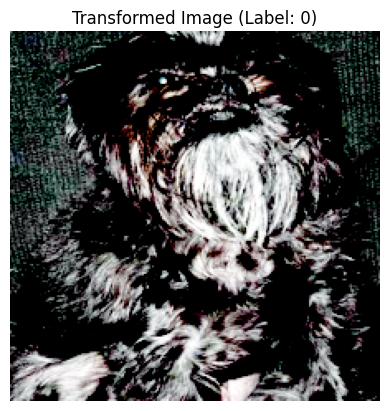

In [54]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Get a single image from the transformed dataset
transformed_image, label = train_dataset[0]
transformed_image_np = transformed_image.numpy().transpose((1, 2, 0))

# Plot the transformed image
plt.figure()
plt.title('Transformed Image (Label: {})'.format(label))
plt.imshow(transformed_image_np)
plt.axis('off')

# Display the image
plt.show()

In [6]:
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="AdamW", lr=lr, weight_decay=0.01
)
# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()


In [36]:
# Create trainer and start training
trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        
        callbacks=[
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
    ],
)

trainer.train(
    per_device_batch_size=batch_size,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    num_epochs=num_epochs,
    create_scheduler_fn=trainer.create_scheduler,
)


Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:08<00:00,  1.44s/it]



train_loss_epoch: 0.3448783755302429


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]



ema_model_accuracy: 0.2751677930355072

accuracy: 0.8724831938743591

eval_loss_epoch: 0.45867112278938293

Starting epoch 2


100%|██████████| 48/48 [01:09<00:00,  1.46s/it]



train_loss_epoch: 0.21890734136104584


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]



ema_model_accuracy: 0.563758373260498

accuracy: 0.9463087320327759

eval_loss_epoch: 0.1495145559310913

Starting epoch 3


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]



train_loss_epoch: 0.1781734973192215


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]



ema_model_accuracy: 0.7953020334243774

accuracy: 0.9664429426193237

eval_loss_epoch: 0.10639917850494385

Starting epoch 4


100%|██████████| 48/48 [01:46<00:00,  2.22s/it]



train_loss_epoch: 0.15030017495155334


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]



ema_model_accuracy: 0.9228187799453735

accuracy: 0.9832214713096619

eval_loss_epoch: 0.05762575939297676

Starting epoch 5


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.13094744086265564


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]



ema_model_accuracy: 0.9530201554298401

accuracy: 0.9798657894134521

eval_loss_epoch: 0.05536247789859772
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 4


## Hyperparameters tuning 

#### Learning rate et smoothing

In [37]:
lr_list=[0.0001,0.0003,0.0006,0.001,0.003]
smoothing_list= [0.01,0.03,0.06,0.1,0.3]

In [38]:
accuracy_dict = {}
for lr in lr_list:
    accuracy_dict[lr] = {}
    for smoothing in smoothing_list:
        model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes)
        mixup_args = dict(
            mixup_alpha=mixup,
            cutmix_alpha=cutmix,
            label_smoothing=smoothing,
            num_classes=num_classes,
        )
        # Create optimizer
        optimizer = timm.optim.create_optimizer_v2(
            model, opt="AdamW", lr=lr, weight_decay=0.01
        )
        # As we are using Mixup, we can use BCE during training and CE for evaluation
        train_loss_fn = timm.loss.BinaryCrossEntropy(
            target_threshold=bce_target_thresh, smoothing=smoothing)
        validate_loss_fn = torch.nn.CrossEntropyLoss()
        
        # Create trainer and start training
        trainer = TimmMixupTrainer(
            model=model,
            optimizer=optimizer,
            loss_func=train_loss_fn,
            eval_loss_fn=validate_loss_fn,
            mixup_args=mixup_args,
            num_classes=num_classes,
            
            callbacks=[
                *DEFAULT_CALLBACKS,
                SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            ],
        )

        trainer.train(
            per_device_batch_size=batch_size,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            num_epochs=num_epochs,
            create_scheduler_fn=trainer.create_scheduler,
        )
        
        accuracy_dict[lr][smoothing] = round(trainer.run_history.get_latest_metric('accuracy').item(), 3)



Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.4104856550693512


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



ema_model_accuracy: 0.23489932715892792

accuracy: 0.11744966357946396

eval_loss_epoch: 2.4978601932525635

Starting epoch 2


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.37580645084381104


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]



ema_model_accuracy: 0.26174497604370117

accuracy: 0.13087248802185059

eval_loss_epoch: 2.4585177898406982

Starting epoch 3


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.3722652196884155


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



ema_model_accuracy: 0.20469798147678375

accuracy: 0.17114093899726868

eval_loss_epoch: 2.4630136489868164

Starting epoch 4


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.3562051057815552


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.1845637559890747

accuracy: 0.21812079846858978

eval_loss_epoch: 2.3585336208343506

Starting epoch 5


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.353598028421402


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.1342281848192215

accuracy: 0.231543630361557

eval_loss_epoch: 2.3511810302734375
Finishing training run
Loading checkpoint with accuracy: 0.231543630361557 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.4039945602416992


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.29530200362205505

accuracy: 0.39261746406555176

eval_loss_epoch: 2.0400054454803467

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.29323795437812805


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



ema_model_accuracy: 0.5469798445701599

accuracy: 0.8557047247886658

eval_loss_epoch: 0.3917334973812103

Starting epoch 3


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.2164277881383896


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.7583892345428467

accuracy: 0.9530201554298401

eval_loss_epoch: 0.16071271896362305

Starting epoch 4


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.17272678017616272


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.8489933013916016

accuracy: 0.9765100479125977

eval_loss_epoch: 0.08445442467927933

Starting epoch 5


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.15853191912174225


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



ema_model_accuracy: 0.9127516746520996

accuracy: 0.9697986841201782

eval_loss_epoch: 0.08167900145053864
Finishing training run
Loading checkpoint with accuracy: 0.9765100479125977 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:05<00:00,  1.36s/it]



train_loss_epoch: 0.3827500641345978


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.3087248206138611

accuracy: 0.6040268540382385

eval_loss_epoch: 1.0446619987487793

Starting epoch 2


100%|██████████| 48/48 [01:06<00:00,  1.40s/it]



train_loss_epoch: 0.24151988327503204


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.6174496412277222

accuracy: 0.9463087320327759

eval_loss_epoch: 0.17741315066814423

Starting epoch 3


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.1952611207962036


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.8389261960983276

accuracy: 0.9798657894134521

eval_loss_epoch: 0.09062428772449493

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.1609051525592804


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.9127516746520996

accuracy: 0.9798657894134521

eval_loss_epoch: 0.07545620203018188

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.14211036264896393


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.9530201554298401

accuracy: 0.9798657894134521

eval_loss_epoch: 0.07628076523542404
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.341164231300354


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.29530200362205505

accuracy: 0.9161073565483093

eval_loss_epoch: 0.36383962631225586

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.21376001834869385


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.6510066986083984

accuracy: 0.963087260723114

eval_loss_epoch: 0.1328212171792984

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.1750272512435913


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.8758389353752136

accuracy: 0.9832214713096619

eval_loss_epoch: 0.07216157019138336

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.14667479693889618


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]



ema_model_accuracy: 0.9597315192222595

accuracy: 0.9798657894134521

eval_loss_epoch: 0.05546984076499939

Starting epoch 5


100%|██████████| 48/48 [01:03<00:00,  1.32s/it]



train_loss_epoch: 0.12867413461208344


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.9731543660163879

accuracy: 0.9832214713096619

eval_loss_epoch: 0.052026569843292236
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.40840861201286316


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.26174497604370117

accuracy: 0.10402684658765793

eval_loss_epoch: 2.5379486083984375

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3503100574016571


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.33892616629600525

accuracy: 0.12080536782741547

eval_loss_epoch: 2.458904266357422

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3559739291667938


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.224832221865654

accuracy: 0.1409395933151245

eval_loss_epoch: 2.477724313735962

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.34519800543785095


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.17449665069580078

accuracy: 0.19127516448497772

eval_loss_epoch: 2.3863346576690674

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.34367603063583374


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.10402684658765793

accuracy: 0.17114093899726868

eval_loss_epoch: 2.381671190261841
Finishing training run
Loading checkpoint with accuracy: 0.19127516448497772 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.4117794930934906


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.23489932715892792

accuracy: 0.08389262109994888

eval_loss_epoch: 2.546074867248535

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3868383765220642


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.25503355264663696

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5798072814941406

Starting epoch 3


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.37662726640701294


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.2214765101671219

accuracy: 0.19798657298088074

eval_loss_epoch: 2.3461015224456787

Starting epoch 4


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.3376641869544983


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



ema_model_accuracy: 0.25503355264663696

accuracy: 0.6241610646247864

eval_loss_epoch: 1.57804536819458

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.39s/it]



train_loss_epoch: 0.2996826469898224


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.2785235047340393

accuracy: 0.6879194378852844

eval_loss_epoch: 1.3517730236053467
Finishing training run
Loading checkpoint with accuracy: 0.6879194378852844 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.4102325439453125


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.24496644735336304

accuracy: 0.09731543809175491

eval_loss_epoch: 2.5526621341705322

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3792467415332794


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]



ema_model_accuracy: 0.2718120813369751

accuracy: 0.10738255083560944

eval_loss_epoch: 2.60097074508667

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.38040873408317566


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.224832221865654

accuracy: 0.16107381880283356

eval_loss_epoch: 2.5482940673828125

Starting epoch 4


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.3606449365615845


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.19127516448497772

accuracy: 0.1845637559890747

eval_loss_epoch: 2.4150195121765137

Starting epoch 5


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.3577254116535187


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.16442953050136566

accuracy: 0.1879194676876068

eval_loss_epoch: 2.409409999847412
Finishing training run
Loading checkpoint with accuracy: 0.1879194676876068 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.40662023425102234


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.231543630361557

accuracy: 0.08389262109994888

eval_loss_epoch: 2.5392467975616455

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3736801743507385


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.25503355264663696

accuracy: 0.12080536782741547

eval_loss_epoch: 2.7567386627197266

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.37314704060554504


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.2751677930355072

accuracy: 0.268456369638443

eval_loss_epoch: 2.188053846359253

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3017053008079529


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.268456369638443

accuracy: 0.8489933013916016

eval_loss_epoch: 0.4938462972640991

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.22296877205371857


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.33892616629600525

accuracy: 0.926174521446228

eval_loss_epoch: 0.3490229547023773
Finishing training run
Loading checkpoint with accuracy: 0.926174521446228 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.40854308009147644


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.231543630361557

accuracy: 0.0906040295958519

eval_loss_epoch: 2.530350923538208

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3747113049030304


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.21812079846858978

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5334227085113525

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3701789081096649


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.20134228467941284

accuracy: 0.16107381880283356

eval_loss_epoch: 2.4432642459869385

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.34608688950538635


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.21140938997268677

accuracy: 0.6510066986083984

eval_loss_epoch: 1.4951109886169434

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.29688477516174316


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.23825503885746002

accuracy: 0.7248322367668152

eval_loss_epoch: 1.242030382156372
Finishing training run
Loading checkpoint with accuracy: 0.7248322367668152 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.40813934803009033


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.24496644735336304

accuracy: 0.08389262109994888

eval_loss_epoch: 2.551731586456299

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3543492257595062


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.25503355264663696

accuracy: 0.10738255083560944

eval_loss_epoch: 2.568394899368286

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3392012417316437


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.30201342701911926

accuracy: 0.7248322367668152

eval_loss_epoch: 1.0202040672302246

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.20959697663784027


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.39261746406555176

accuracy: 0.9563758373260498

eval_loss_epoch: 0.18132886290550232

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.1737598478794098


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.573825478553772

accuracy: 0.9731543660163879

eval_loss_epoch: 0.14691272377967834
Finishing training run
Loading checkpoint with accuracy: 0.9731543660163879 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.4137319326400757


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.25838926434516907

accuracy: 0.0906040295958519

eval_loss_epoch: 2.5503077507019043

Starting epoch 2


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.3877065181732178


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



ema_model_accuracy: 0.281879186630249

accuracy: 0.12751677632331848

eval_loss_epoch: 2.647672414779663

Starting epoch 3


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.38224804401397705


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.21476510167121887

accuracy: 0.1342281848192215

eval_loss_epoch: 2.558476686477661

Starting epoch 4


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.36019325256347656


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]



ema_model_accuracy: 0.19463087618350983

accuracy: 0.1879194676876068

eval_loss_epoch: 2.392237424850464

Starting epoch 5


100%|██████████| 48/48 [01:07<00:00,  1.40s/it]



train_loss_epoch: 0.35618704557418823


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.19463087618350983

accuracy: 0.21140938997268677

eval_loss_epoch: 2.386571168899536
Finishing training run
Loading checkpoint with accuracy: 0.21140938997268677 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.410847932100296


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.25167784094810486

accuracy: 0.07718120515346527

eval_loss_epoch: 2.530618906021118

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3863945007324219


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.2785235047340393

accuracy: 0.11744966357946396

eval_loss_epoch: 2.6595726013183594

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.38391488790512085


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.231543630361557

accuracy: 0.15771812200546265

eval_loss_epoch: 2.5527265071868896

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.35916420817375183


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.1845637559890747

accuracy: 0.20805369317531586

eval_loss_epoch: 2.3722941875457764

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3551709055900574


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.1342281848192215

accuracy: 0.224832221865654

eval_loss_epoch: 2.3654110431671143
Finishing training run
Loading checkpoint with accuracy: 0.224832221865654 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:57<00:00,  1.21s/it]



train_loss_epoch: 0.3464200794696808


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]



ema_model_accuracy: 0.34899330139160156

accuracy: 0.8624160885810852

eval_loss_epoch: 0.42424818873405457

Starting epoch 2


100%|██████████| 48/48 [00:58<00:00,  1.21s/it]



train_loss_epoch: 0.30995264649391174


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]



ema_model_accuracy: 0.7651006579399109

accuracy: 0.681208074092865

eval_loss_epoch: 1.0541856288909912

Starting epoch 3


100%|██████████| 48/48 [00:58<00:00,  1.22s/it]



train_loss_epoch: 0.2689080536365509


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]



ema_model_accuracy: 0.9463087320327759

accuracy: 0.8758389353752136

eval_loss_epoch: 0.4102119505405426

Starting epoch 4


100%|██████████| 48/48 [00:58<00:00,  1.22s/it]



train_loss_epoch: 0.20529970526695251


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



ema_model_accuracy: 0.9664429426193237

accuracy: 0.9429529905319214

eval_loss_epoch: 0.1834397166967392

Starting epoch 5


100%|██████████| 48/48 [00:58<00:00,  1.22s/it]



train_loss_epoch: 0.17741119861602783


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]



ema_model_accuracy: 0.9865771532058716

accuracy: 0.9463087320327759

eval_loss_epoch: 0.17239375412464142
Finishing training run
Loading checkpoint with accuracy: 0.9463087320327759 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.40682411193847656


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.24161073565483093

accuracy: 0.08389262109994888

eval_loss_epoch: 2.5490903854370117

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3804565668106079


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



ema_model_accuracy: 0.24161073565483093

accuracy: 0.10738255083560944

eval_loss_epoch: 2.697042465209961

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.37850114703178406


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.20134228467941284

accuracy: 0.1342281848192215

eval_loss_epoch: 2.6032190322875977

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.36327388882637024


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.19127516448497772

accuracy: 0.15100671350955963

eval_loss_epoch: 2.4549434185028076

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3573357164859772


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.1778523474931717

accuracy: 0.15100671350955963

eval_loss_epoch: 2.452181100845337
Finishing training run
Loading checkpoint with accuracy: 0.15100671350955963 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.4069003164768219


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.231543630361557

accuracy: 0.08389262109994888

eval_loss_epoch: 2.573953866958618

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3618816137313843


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.224832221865654

accuracy: 0.11744966357946396

eval_loss_epoch: 2.7892115116119385

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.36882203817367554


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]



ema_model_accuracy: 0.21476510167121887

accuracy: 0.1375838965177536

eval_loss_epoch: 2.5842959880828857

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3484008312225342


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.1375838965177536

accuracy: 0.19798657298088074

eval_loss_epoch: 2.4240620136260986

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.34632107615470886


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.09731543809175491

accuracy: 0.1812080591917038

eval_loss_epoch: 2.4198973178863525
Finishing training run
Loading checkpoint with accuracy: 0.19798657298088074 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.354667991399765


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.3657718002796173

accuracy: 0.8724831938743591

eval_loss_epoch: 0.42598721385002136

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.4155738353729248


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.16778524219989777

accuracy: 0.10738255083560944

eval_loss_epoch: 2.732083320617676

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3866381049156189


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.0939597338438034

accuracy: 0.07718120515346527

eval_loss_epoch: 2.621537446975708

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3643507659435272


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.1342281848192215

eval_loss_epoch: 2.477245807647705

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3622453510761261


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.12751677632331848

eval_loss_epoch: 2.47530460357666
Finishing training run
Loading checkpoint with accuracy: 0.8724831938743591 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.41174444556236267


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.2651006579399109

accuracy: 0.08389262109994888

eval_loss_epoch: 2.558821201324463

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3903449475765228


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.21476510167121887

accuracy: 0.07718120515346527

eval_loss_epoch: 2.796217203140259

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3866114020347595


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.07718120515346527

eval_loss_epoch: 2.618014335632324

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3636215031147003


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.1409395933151245

eval_loss_epoch: 2.469815492630005

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.36151349544525146


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.09731543809175491

accuracy: 0.16778524219989777

eval_loss_epoch: 2.4667346477508545
Finishing training run
Loading checkpoint with accuracy: 0.16778524219989777 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.40767747163772583


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.2718120813369751

accuracy: 0.08389262109994888

eval_loss_epoch: 2.5500452518463135

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3958430886268616


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.30536913871765137

accuracy: 0.10738255083560944

eval_loss_epoch: 2.9264614582061768

Starting epoch 3


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.38561439514160156


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.0939597338438034

accuracy: 0.1375838965177536

eval_loss_epoch: 2.5917770862579346

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.3628380596637726


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.10402684658765793

accuracy: 0.1375838965177536

eval_loss_epoch: 2.4506900310516357

Starting epoch 5


100%|██████████| 48/48 [01:03<00:00,  1.31s/it]



train_loss_epoch: 0.3571779429912567


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



ema_model_accuracy: 0.10402684658765793

accuracy: 0.14765100181102753

eval_loss_epoch: 2.448052406311035
Finishing training run
Loading checkpoint with accuracy: 0.14765100181102753 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.41230085492134094


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.26174497604370117

accuracy: 0.08389262109994888

eval_loss_epoch: 2.578239679336548

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.3851763904094696


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.23825503885746002

accuracy: 0.13087248802185059

eval_loss_epoch: 2.7848401069641113

Starting epoch 3


100%|██████████| 48/48 [01:03<00:00,  1.31s/it]



train_loss_epoch: 0.37871038913726807


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.11744966357946396

accuracy: 0.07718120515346527

eval_loss_epoch: 2.6148416996002197

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.36214175820350647


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.23489932715892792

eval_loss_epoch: 2.3980653285980225

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.354394793510437


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.25167784094810486

eval_loss_epoch: 2.392210006713867
Finishing training run
Loading checkpoint with accuracy: 0.25167784094810486 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.34832248091697693


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.34228187799453735

accuracy: 0.8489933013916016

eval_loss_epoch: 0.41815778613090515

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.31s/it]



train_loss_epoch: 0.36976268887519836


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.2718120813369751

accuracy: 0.10738255083560944

eval_loss_epoch: 2.9028210639953613

Starting epoch 3


100%|██████████| 48/48 [01:34<00:00,  1.97s/it]



train_loss_epoch: 0.3736696243286133


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]



ema_model_accuracy: 0.1879194676876068

accuracy: 0.08724832534790039

eval_loss_epoch: 2.665377378463745

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.3514225482940674


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.1375838965177536

eval_loss_epoch: 2.4716100692749023

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.3495175540447235


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.10067114233970642

accuracy: 0.1375838965177536

eval_loss_epoch: 2.468904733657837
Finishing training run
Loading checkpoint with accuracy: 0.8489933013916016 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.4135160446166992


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.25838926434516907

accuracy: 0.0939597338438034

eval_loss_epoch: 2.5732169151306152

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.419189453125


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.14765100181102753

accuracy: 0.08389262109994888

eval_loss_epoch: 2.896167755126953

Starting epoch 3


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.3945659101009369


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.08053690940141678

eval_loss_epoch: 2.583162546157837

Starting epoch 4


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.36446332931518555


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.11073825508356094

eval_loss_epoch: 2.4809889793395996

Starting epoch 5


100%|██████████| 48/48 [01:02<00:00,  1.30s/it]



train_loss_epoch: 0.362491250038147


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.11073825508356094

eval_loss_epoch: 2.4798777103424072
Finishing training run
Loading checkpoint with accuracy: 0.11073825508356094 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.4114515483379364


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.268456369638443

accuracy: 0.11744966357946396

eval_loss_epoch: 2.5960395336151123

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.418489009141922


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.1409395933151245

accuracy: 0.08053690940141678

eval_loss_epoch: 2.924945831298828

Starting epoch 3


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.3936096429824829


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.08389262109994888

accuracy: 0.0906040295958519

eval_loss_epoch: 2.572903633117676

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.3664035499095917


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.08389262109994888

accuracy: 0.10738255083560944

eval_loss_epoch: 2.495648145675659

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.3634558618068695


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.08389262109994888

accuracy: 0.10738255083560944

eval_loss_epoch: 2.494041681289673
Finishing training run
Loading checkpoint with accuracy: 0.11744966357946396 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.360027551651001


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



ema_model_accuracy: 0.33557048439979553

accuracy: 0.7885906100273132

eval_loss_epoch: 0.6113628149032593

Starting epoch 2


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]



train_loss_epoch: 0.4741901457309723


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.08053690940141678

eval_loss_epoch: 3.195713520050049

Starting epoch 3


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.40242889523506165


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.07718120515346527

accuracy: 0.07382550090551376

eval_loss_epoch: 2.5830159187316895

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.368638813495636


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.08053690940141678

accuracy: 0.08724832534790039

eval_loss_epoch: 2.502063751220703

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.36139875650405884


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.08053690940141678

accuracy: 0.0906040295958519

eval_loss_epoch: 2.4995412826538086
Finishing training run
Loading checkpoint with accuracy: 0.7885906100273132 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.36614394187927246


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



ema_model_accuracy: 0.3120805323123932

accuracy: 0.7416107654571533

eval_loss_epoch: 0.7011518478393555

Starting epoch 2


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.4882846176624298


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.08053690940141678

eval_loss_epoch: 2.957514524459839

Starting epoch 3


100%|██████████| 48/48 [01:05<00:00,  1.37s/it]



train_loss_epoch: 0.3908078968524933


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.07382550090551376

eval_loss_epoch: 2.6785433292388916

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.36846476793289185


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.10738255083560944

eval_loss_epoch: 2.494997262954712

Starting epoch 5


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.35987597703933716


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.10738255083560944

eval_loss_epoch: 2.4936442375183105
Finishing training run
Loading checkpoint with accuracy: 0.7416107654571533 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.4080398976802826


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.231543630361557

accuracy: 0.10402684658765793

eval_loss_epoch: 2.5220508575439453

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.6090413331985474


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.0906040295958519

eval_loss_epoch: 3.0267879962921143

Starting epoch 3


100%|██████████| 48/48 [01:03<00:00,  1.32s/it]



train_loss_epoch: 0.4029221832752228


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]



ema_model_accuracy: 0.057046979665756226

accuracy: 0.0906040295958519

eval_loss_epoch: 2.6604273319244385

Starting epoch 4


100%|██████████| 48/48 [01:06<00:00,  1.38s/it]



train_loss_epoch: 0.35927334427833557


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.07718120515346527

accuracy: 0.10738255083560944

eval_loss_epoch: 2.535806179046631

Starting epoch 5


100%|██████████| 48/48 [01:05<00:00,  1.37s/it]



train_loss_epoch: 0.3571520447731018


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]



ema_model_accuracy: 0.07718120515346527

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5262908935546875
Finishing training run
Loading checkpoint with accuracy: 0.10738255083560944 from epoch 4


In [39]:
accuracy_dict

{0.0001: {0.01: 0.232, 0.03: 0.97, 0.06: 0.98, 0.1: 0.983, 0.3: 0.171},
 0.0003: {0.01: 0.688, 0.03: 0.188, 0.06: 0.926, 0.1: 0.725, 0.3: 0.973},
 0.0006: {0.01: 0.211, 0.03: 0.225, 0.06: 0.946, 0.1: 0.151, 0.3: 0.181},
 0.001: {0.01: 0.128, 0.03: 0.168, 0.06: 0.148, 0.1: 0.252, 0.3: 0.138},
 0.003: {0.01: 0.111, 0.03: 0.107, 0.06: 0.091, 0.1: 0.107, 0.3: 0.107}}

In [40]:
df = pd.DataFrame.from_dict(accuracy_dict, orient='columns')

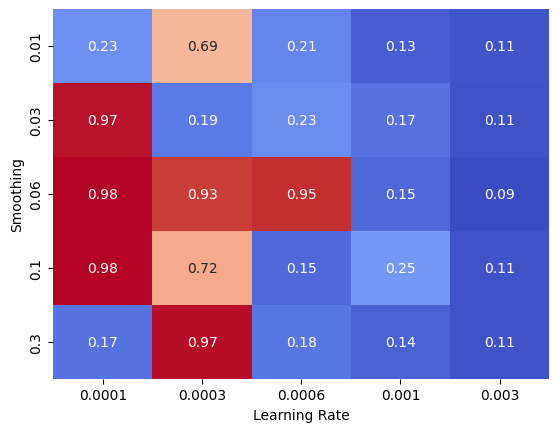

In [41]:
# create the heatmap
sns.heatmap(df, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)

# set the axis labels
plt.xlabel('Learning Rate')
plt.ylabel('Smoothing')

# show the plot
plt.show()

#### Batch size et mixup

In [7]:
batch_size_list = [8,16,32]
mixup_list= [0.5,0.2,0.08,0.05,0.02]
smoothing=0.1
lr=0.0001

In [8]:
accuracy_dict = {}
for batch_size in batch_size_list:
    accuracy_dict[batch_size] = {}
    for mixup in mixup_list:
        model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes)
        mixup_args = dict(
            mixup_alpha=mixup,
            cutmix_alpha=cutmix,
            label_smoothing=smoothing,
            num_classes=num_classes,
        )
        # Create optimizer
        optimizer = timm.optim.create_optimizer_v2(
            model, opt="AdamW", lr=lr, weight_decay=0.01
        )
        # As we are using Mixup, we can use BCE during training and CE for evaluation
        train_loss_fn = timm.loss.BinaryCrossEntropy(
            target_threshold=bce_target_thresh, smoothing=smoothing)
        validate_loss_fn = torch.nn.CrossEntropyLoss()
        
        # Create trainer and start training
        trainer = TimmMixupTrainer(
            model=model,
            optimizer=optimizer,
            loss_func=train_loss_fn,
            eval_loss_fn=validate_loss_fn,
            mixup_args=mixup_args,
            num_classes=num_classes,
            
            callbacks=[
                *DEFAULT_CALLBACKS,
                SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            ],
        )

        trainer.train(
            per_device_batch_size=batch_size,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            num_epochs=num_epochs,
            create_scheduler_fn=trainer.create_scheduler,
        )
        
        accuracy_dict[batch_size][mixup] = round(trainer.run_history.get_latest_metric('accuracy').item(), 3)


Starting training run

Starting epoch 1


100%|██████████| 190/190 [01:17<00:00,  2.46it/s]



train_loss_epoch: 0.4110141694545746


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]



eval_loss_epoch: 2.6232802867889404

ema_model_accuracy: 0.11744966357946396

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.38803625106811523


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]



eval_loss_epoch: 2.418704032897949

ema_model_accuracy: 0.21812079846858978

accuracy: 0.2281879186630249

Starting epoch 3


100%|██████████| 190/190 [01:14<00:00,  2.54it/s]



train_loss_epoch: 0.2951274514198303


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]



eval_loss_epoch: 0.3021913766860962

ema_model_accuracy: 0.48322147130966187

accuracy: 0.899328887462616

Starting epoch 4


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.20998051762580872


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]



eval_loss_epoch: 0.1560782939195633

ema_model_accuracy: 0.6476510167121887

accuracy: 0.9429529905319214

Starting epoch 5


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.1866428703069687


100%|██████████| 38/38 [00:16<00:00,  2.32it/s]



eval_loss_epoch: 0.10257168114185333

ema_model_accuracy: 0.755033552646637

accuracy: 0.9731543660163879
Finishing training run
Loading checkpoint with accuracy: 0.9731543660163879 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.3883429765701294


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.609987258911133

ema_model_accuracy: 0.19463087618350983

accuracy: 0.08389262109994888

Starting epoch 2


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.3756985664367676


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.5482983589172363

ema_model_accuracy: 0.17114093899726868

accuracy: 0.1375838965177536

Starting epoch 3


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.35238486528396606


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 2.4405035972595215

ema_model_accuracy: 0.21476510167121887

accuracy: 0.12751677632331848

Starting epoch 4


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.3494951128959656


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]



eval_loss_epoch: 1.944339394569397

ema_model_accuracy: 0.21140938997268677

accuracy: 0.3221476376056671

Starting epoch 5


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.31255820393562317


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 1.4050383567810059

ema_model_accuracy: 0.21140938997268677

accuracy: 0.5939597487449646
Finishing training run
Loading checkpoint with accuracy: 0.5939597487449646 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.3794656991958618


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 2.5821237564086914

ema_model_accuracy: 0.19127516448497772

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.3645334243774414


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.5662033557891846

ema_model_accuracy: 0.16778524219989777

accuracy: 0.13087248802185059

Starting epoch 3


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.34026357531547546


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 2.128848075866699

ema_model_accuracy: 0.21140938997268677

accuracy: 0.25167784094810486

Starting epoch 4


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.2699689567089081


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 0.48021435737609863

ema_model_accuracy: 0.3087248206138611

accuracy: 0.8154362440109253

Starting epoch 5


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.19367635250091553


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]



eval_loss_epoch: 0.19748465716838837

ema_model_accuracy: 0.3758389353752136

accuracy: 0.9563758373260498
Finishing training run
Loading checkpoint with accuracy: 0.9563758373260498 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.37738037109375


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.5700690746307373

ema_model_accuracy: 0.1879194676876068

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.3667353689670563


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]



eval_loss_epoch: 2.6219894886016846

ema_model_accuracy: 0.16778524219989777

accuracy: 0.07382550090551376

Starting epoch 3


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.3473193049430847


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]



eval_loss_epoch: 2.4643094539642334

ema_model_accuracy: 0.20134228467941284

accuracy: 0.1375838965177536

Starting epoch 4


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.3464603126049042


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.286421537399292

ema_model_accuracy: 0.15771812200546265

accuracy: 0.24161073565483093

Starting epoch 5


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.3398199677467346


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 2.2354798316955566

ema_model_accuracy: 0.12080536782741547

accuracy: 0.2651006579399109
Finishing training run
Loading checkpoint with accuracy: 0.2651006579399109 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 190/190 [01:13<00:00,  2.57it/s]



train_loss_epoch: 0.3753513693809509


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 2.594155788421631

ema_model_accuracy: 0.17114093899726868

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.3674057126045227


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]



eval_loss_epoch: 2.5829672813415527

ema_model_accuracy: 0.14765100181102753

accuracy: 0.1342281848192215

Starting epoch 3


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.33990344405174255


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]



eval_loss_epoch: 2.2485225200653076

ema_model_accuracy: 0.1778523474931717

accuracy: 0.16107381880283356

Starting epoch 4


100%|██████████| 190/190 [01:14<00:00,  2.57it/s]



train_loss_epoch: 0.28113627433776855


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]



eval_loss_epoch: 0.6892644762992859

ema_model_accuracy: 0.2214765101671219

accuracy: 0.755033552646637

Starting epoch 5


100%|██████████| 190/190 [01:14<00:00,  2.56it/s]



train_loss_epoch: 0.1959231197834015


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]



eval_loss_epoch: 0.26226311922073364

ema_model_accuracy: 0.25503355264663696

accuracy: 0.9429529905319214
Finishing training run
Loading checkpoint with accuracy: 0.9429529905319214 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.4097726345062256


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 2.590244770050049

ema_model_accuracy: 0.19463087618350983

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.3860013484954834


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 2.585395574569702

ema_model_accuracy: 0.1879194676876068

accuracy: 0.07382550090551376

Starting epoch 3


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.3835704028606415


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 2.506269693374634

ema_model_accuracy: 0.25167784094810486

accuracy: 0.10402684658765793

Starting epoch 4


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.3741134703159332


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 2.4532930850982666

ema_model_accuracy: 0.1845637559890747

accuracy: 0.10738255083560944

Starting epoch 5


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.38164716958999634


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.4514243602752686

ema_model_accuracy: 0.0939597338438034

accuracy: 0.10738255083560944
Finishing training run
Loading checkpoint with accuracy: 0.10738255083560944 from epoch 1

Starting training run

Starting epoch 1


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.3971019387245178


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.641997814178467

ema_model_accuracy: 0.21812079846858978

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.3530142903327942


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.5955206155776978

ema_model_accuracy: 0.3557046949863434

accuracy: 0.8389261960983276

Starting epoch 3


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.23539693653583527


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.15872643887996674

ema_model_accuracy: 0.6677852272987366

accuracy: 0.9530201554298401

Starting epoch 4


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.15841460227966309


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.06124730035662651

ema_model_accuracy: 0.8456375598907471

accuracy: 0.9798657894134521

Starting epoch 5


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.15051497519016266


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.05840051919221878

ema_model_accuracy: 0.9161073565483093

accuracy: 0.9765100479125977
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.37673282623291016


100%|██████████| 19/19 [00:16<00:00,  1.16it/s]



eval_loss_epoch: 2.5498592853546143

ema_model_accuracy: 0.231543630361557

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.3680039346218109


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.169066905975342

ema_model_accuracy: 0.2214765101671219

accuracy: 0.2718120813369751

Starting epoch 3


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.26557260751724243


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 0.2682356834411621

ema_model_accuracy: 0.28523489832878113

accuracy: 0.926174521446228

Starting epoch 4


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.15027809143066406


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.09299264848232269

ema_model_accuracy: 0.3557046949863434

accuracy: 0.9765100479125977

Starting epoch 5


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.15268093347549438


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.08535988628864288

ema_model_accuracy: 0.5201342105865479

accuracy: 0.9731543660163879
Finishing training run
Loading checkpoint with accuracy: 0.9765100479125977 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.374188095331192


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.5853469371795654

ema_model_accuracy: 0.2214765101671219

accuracy: 0.10738255083560944

Starting epoch 2


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.36909350752830505


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.5319604873657227

ema_model_accuracy: 0.20134228467941284

accuracy: 0.10738255083560944

Starting epoch 3


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.365580290555954


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 2.445600748062134

ema_model_accuracy: 0.1778523474931717

accuracy: 0.1375838965177536

Starting epoch 4


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.3385714292526245


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 2.3243961334228516

ema_model_accuracy: 0.14765100181102753

accuracy: 0.20805369317531586

Starting epoch 5


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.34437572956085205


100%|██████████| 19/19 [00:16<00:00,  1.12it/s]



eval_loss_epoch: 2.3156702518463135

ema_model_accuracy: 0.08389262109994888

accuracy: 0.1879194676876068
Finishing training run
Loading checkpoint with accuracy: 0.20805369317531586 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.3133643567562103


100%|██████████| 19/19 [00:16<00:00,  1.15it/s]



eval_loss_epoch: 0.42410534620285034

ema_model_accuracy: 0.3288590610027313

accuracy: 0.8691275119781494

Starting epoch 2


100%|██████████| 95/95 [01:10<00:00,  1.35it/s]



train_loss_epoch: 0.21863703429698944


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]



eval_loss_epoch: 0.22712589800357819

ema_model_accuracy: 0.6241610646247864

accuracy: 0.926174521446228

Starting epoch 3


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.1580081582069397


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]



eval_loss_epoch: 0.10245049744844437

ema_model_accuracy: 0.8523489832878113

accuracy: 0.963087260723114

Starting epoch 4


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.11077244579792023


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]



eval_loss_epoch: 0.08086740970611572

ema_model_accuracy: 0.9228187799453735

accuracy: 0.9731543660163879

Starting epoch 5


100%|██████████| 95/95 [01:10<00:00,  1.34it/s]



train_loss_epoch: 0.10916627198457718


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]



eval_loss_epoch: 0.07641161233186722

ema_model_accuracy: 0.9664429426193237

accuracy: 0.9731543660163879
Finishing training run
Loading checkpoint with accuracy: 0.9731543660163879 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [6:37:40<00:00, 497.09s/it]  



train_loss_epoch: 0.42408889532089233


100%|██████████| 10/10 [45:03<00:00, 270.39s/it]



eval_loss_epoch: 2.5616536140441895

ema_model_accuracy: 0.20805369317531586

accuracy: 0.10402684658765793

Starting epoch 2


100%|██████████| 48/48 [01:55<00:00,  2.41s/it]



train_loss_epoch: 0.38628941774368286


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]



eval_loss_epoch: 2.5122904777526855

ema_model_accuracy: 0.21812079846858978

accuracy: 0.10738255083560944

Starting epoch 3


100%|██████████| 48/48 [01:22<00:00,  1.73s/it]



train_loss_epoch: 0.36935633420944214


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]



eval_loss_epoch: 2.5038228034973145

ema_model_accuracy: 0.1409395933151245

accuracy: 0.14429530501365662

Starting epoch 4


100%|██████████| 48/48 [01:27<00:00,  1.83s/it]



train_loss_epoch: 0.38678601384162903


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]



eval_loss_epoch: 2.4456124305725098

ema_model_accuracy: 0.10402684658765793

accuracy: 0.12080536782741547

Starting epoch 5


100%|██████████| 48/48 [01:18<00:00,  1.63s/it]



train_loss_epoch: 0.38817909359931946


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]



eval_loss_epoch: 2.4442050457000732

ema_model_accuracy: 0.0906040295958519

accuracy: 0.12416107207536697
Finishing training run
Loading checkpoint with accuracy: 0.14429530501365662 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:23<00:00,  1.73s/it]



train_loss_epoch: 0.37518829107284546


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]



eval_loss_epoch: 0.6462976932525635

ema_model_accuracy: 0.30201342701911926

accuracy: 0.7617449760437012

Starting epoch 2


100%|██████████| 48/48 [01:26<00:00,  1.81s/it]



train_loss_epoch: 0.22954343259334564


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]



eval_loss_epoch: 0.15807633101940155

ema_model_accuracy: 0.6174496412277222

accuracy: 0.9496644139289856

Starting epoch 3


100%|██████████| 48/48 [01:24<00:00,  1.75s/it]



train_loss_epoch: 0.18057255446910858


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]



eval_loss_epoch: 0.06620922684669495

ema_model_accuracy: 0.8389261960983276

accuracy: 0.9798657894134521

Starting epoch 4


100%|██████████| 48/48 [01:38<00:00,  2.05s/it]



train_loss_epoch: 0.15692013502120972


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]



eval_loss_epoch: 0.05901758000254631

ema_model_accuracy: 0.9395973086357117

accuracy: 0.9865771532058716

Starting epoch 5


100%|██████████| 48/48 [01:16<00:00,  1.60s/it]



train_loss_epoch: 0.1345563530921936


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]



eval_loss_epoch: 0.0574902705848217

ema_model_accuracy: 0.9765100479125977

accuracy: 0.9832214713096619
Finishing training run
Loading checkpoint with accuracy: 0.9865771532058716 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:23<00:00,  1.75s/it]



train_loss_epoch: 0.39414912462234497


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]



eval_loss_epoch: 2.5118932723999023

ema_model_accuracy: 0.224832221865654

accuracy: 0.0939597338438034

Starting epoch 2


100%|██████████| 48/48 [01:23<00:00,  1.74s/it]



train_loss_epoch: 0.31928542256355286


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]



eval_loss_epoch: 0.8731107711791992

ema_model_accuracy: 0.37919461727142334

accuracy: 0.7281879186630249

Starting epoch 3


100%|██████████| 48/48 [01:22<00:00,  1.71s/it]



train_loss_epoch: 0.25437766313552856


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]



eval_loss_epoch: 0.17576463520526886

ema_model_accuracy: 0.5536912679672241

accuracy: 0.963087260723114

Starting epoch 4


100%|██████████| 48/48 [01:20<00:00,  1.67s/it]



train_loss_epoch: 0.15768785774707794


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]



eval_loss_epoch: 0.08782681077718735

ema_model_accuracy: 0.681208074092865

accuracy: 0.9798657894134521

Starting epoch 5


100%|██████████| 48/48 [01:09<00:00,  1.45s/it]



train_loss_epoch: 0.16454839706420898


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]



eval_loss_epoch: 0.08489754050970078

ema_model_accuracy: 0.791946291923523

accuracy: 0.9765100479125977
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:43<00:00,  2.16s/it]



train_loss_epoch: 0.31928861141204834


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]



eval_loss_epoch: 0.4664011299610138

ema_model_accuracy: 0.3657718002796173

accuracy: 0.8456375598907471

Starting epoch 2


100%|██████████| 48/48 [01:18<00:00,  1.64s/it]



train_loss_epoch: 0.18148936331272125


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]



eval_loss_epoch: 0.1949094533920288

ema_model_accuracy: 0.6677852272987366

accuracy: 0.9295302033424377

Starting epoch 3


100%|██████████| 48/48 [01:12<00:00,  1.51s/it]



train_loss_epoch: 0.18134956061840057


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]



eval_loss_epoch: 0.08354808390140533

ema_model_accuracy: 0.8691275119781494

accuracy: 0.9832214713096619

Starting epoch 4


100%|██████████| 48/48 [01:15<00:00,  1.56s/it]



train_loss_epoch: 0.11937753111124039


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]



eval_loss_epoch: 0.06124477833509445

ema_model_accuracy: 0.9563758373260498

accuracy: 0.9832214713096619

Starting epoch 5


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]



train_loss_epoch: 0.12357419729232788


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



eval_loss_epoch: 0.05705014243721962

ema_model_accuracy: 0.9697986841201782

accuracy: 0.9832214713096619
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:11<00:00,  1.50s/it]



train_loss_epoch: 0.38182932138442993


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]



eval_loss_epoch: 2.531581401824951

ema_model_accuracy: 0.2214765101671219

accuracy: 0.10402684658765793

Starting epoch 2


100%|██████████| 48/48 [01:21<00:00,  1.69s/it]



train_loss_epoch: 0.3473512828350067


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]



eval_loss_epoch: 2.0306499004364014

ema_model_accuracy: 0.24496644735336304

accuracy: 0.25838926434516907

Starting epoch 3


100%|██████████| 48/48 [01:11<00:00,  1.50s/it]



train_loss_epoch: 0.3017077147960663


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]



eval_loss_epoch: 0.3791232407093048

ema_model_accuracy: 0.3322147727012634

accuracy: 0.9563758373260498

Starting epoch 4


100%|██████████| 48/48 [01:13<00:00,  1.53s/it]



train_loss_epoch: 0.17770206928253174


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]



eval_loss_epoch: 0.16452538967132568

ema_model_accuracy: 0.4563758373260498

accuracy: 0.9563758373260498

Starting epoch 5


100%|██████████| 48/48 [01:08<00:00,  1.42s/it]



train_loss_epoch: 0.17471198737621307


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



eval_loss_epoch: 0.13634826242923737

ema_model_accuracy: 0.6040268540382385

accuracy: 0.9664429426193237
Finishing training run
Loading checkpoint with accuracy: 0.9664429426193237 from epoch 5


In [9]:
accuracy_dict

{8: {0.5: 0.973, 0.2: 0.594, 0.08: 0.956, 0.05: 0.265, 0.02: 0.943},
 16: {0.5: 0.107, 0.2: 0.977, 0.08: 0.973, 0.05: 0.188, 0.02: 0.973},
 32: {0.5: 0.124, 0.2: 0.983, 0.08: 0.977, 0.05: 0.983, 0.02: 0.966}}

In [12]:
df = pd.DataFrame.from_dict(accuracy_dict, orient='columns')

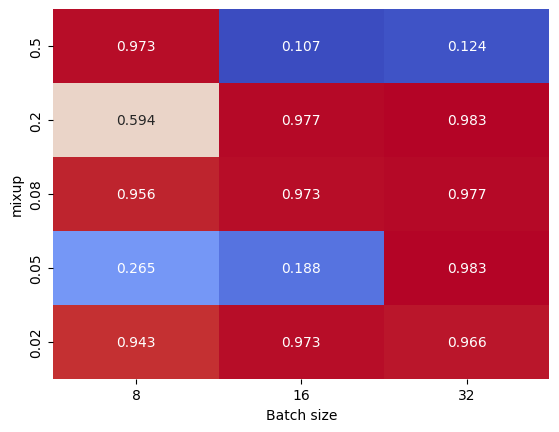

In [13]:
# create the heatmap
sns.heatmap(df, annot=True, fmt=".3f", cmap='coolwarm', cbar=False)

# set the axis labels
plt.xlabel('Batch size')
plt.ylabel('mixup')

# show the plot
plt.show()

#### bce_target et weight decay

In [4]:
bce_target_list=[0.1,0.2,0.4,0.6,0.8]
decay_list=[0.1,0.01,0.001,0.0001]
batch_size=32
mixup=0.2

In [14]:
accuracy_dict = {}
for decay in decay_list:
    accuracy_dict[decay] = {}
    for bce_target_thresh in bce_target_list:
        model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes)
        mixup_args = dict(
            mixup_alpha=mixup,
            cutmix_alpha=cutmix,
            label_smoothing=smoothing,
            num_classes=num_classes,
        )
        # Create optimizer
        optimizer = timm.optim.create_optimizer_v2(
            model, opt="AdamW", lr=lr, weight_decay=decay
        )
        # As we are using Mixup, we can use BCE during training and CE for evaluation
        train_loss_fn = timm.loss.BinaryCrossEntropy(
            target_threshold=bce_target_thresh, smoothing=smoothing)
        validate_loss_fn = torch.nn.CrossEntropyLoss()
        
        # Create trainer and start training
        trainer = TimmMixupTrainer(
            model=model,
            optimizer=optimizer,
            loss_func=train_loss_fn,
            eval_loss_fn=validate_loss_fn,
            mixup_args=mixup_args,
            num_classes=num_classes,
            
            callbacks=[
                *DEFAULT_CALLBACKS,
                SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            ],
        )

        trainer.train(
            per_device_batch_size=batch_size,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            num_epochs=num_epochs,
            create_scheduler_fn=trainer.create_scheduler,
        )
        
        accuracy_dict[decay][bce_target_thresh] = round(trainer.run_history.get_latest_metric('accuracy').item(), 3)


Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:16<00:00,  1.58s/it]



train_loss_epoch: 0.3487453758716583


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.2751677930355072

accuracy: 0.8523489832878113

eval_loss_epoch: 0.4366171360015869

Starting epoch 2


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.24742166697978973


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.6442952752113342

accuracy: 0.963087260723114

eval_loss_epoch: 0.1531522423028946

Starting epoch 3


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.20957334339618683


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



ema_model_accuracy: 0.8926174640655518

accuracy: 0.9865771532058716

eval_loss_epoch: 0.07166384160518646

Starting epoch 4


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.16406622529029846


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.963087260723114

accuracy: 0.9798657894134521

eval_loss_epoch: 0.06323512643575668

Starting epoch 5


100%|██████████| 48/48 [00:59<00:00,  1.25s/it]



train_loss_epoch: 0.15845464169979095


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.9832214713096619

accuracy: 0.9832214713096619

eval_loss_epoch: 0.056487180292606354
Finishing training run
Loading checkpoint with accuracy: 0.9865771532058716 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]



train_loss_epoch: 0.3450523912906647


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



ema_model_accuracy: 0.34563758969306946

accuracy: 0.8791946172714233

eval_loss_epoch: 0.37256550788879395

Starting epoch 2


100%|██████████| 48/48 [01:02<00:00,  1.29s/it]



train_loss_epoch: 0.21967144310474396


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.6879194378852844

accuracy: 0.9530201554298401

eval_loss_epoch: 0.14237846434116364

Starting epoch 3


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.18023917078971863


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



ema_model_accuracy: 0.8825503587722778

accuracy: 0.9865771532058716

eval_loss_epoch: 0.06569201499223709

Starting epoch 4


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.1525176614522934


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



ema_model_accuracy: 0.9530201554298401

accuracy: 0.9798657894134521

eval_loss_epoch: 0.06314366310834885

Starting epoch 5


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]



train_loss_epoch: 0.13291436433792114


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



ema_model_accuracy: 0.9731543660163879

accuracy: 0.9798657894134521

eval_loss_epoch: 0.062336307018995285
Finishing training run
Loading checkpoint with accuracy: 0.9865771532058716 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.2669033408164978


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.33892616629600525

accuracy: 0.8959731459617615

eval_loss_epoch: 0.31982603669166565

Starting epoch 2


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.13237525522708893


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



ema_model_accuracy: 0.6610738039016724

accuracy: 0.963087260723114

eval_loss_epoch: 0.12319312989711761

Starting epoch 3


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.11769967526197433


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.8859060406684875

accuracy: 0.9765100479125977

eval_loss_epoch: 0.08266951143741608

Starting epoch 4


100%|██████████| 48/48 [00:59<00:00,  1.25s/it]



train_loss_epoch: 0.08041523396968842


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.9463087320327759

accuracy: 0.9899328947067261

eval_loss_epoch: 0.04866700991988182

Starting epoch 5


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.07717766612768173


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.9832214713096619

accuracy: 0.9899328947067261

eval_loss_epoch: 0.04681354761123657
Finishing training run
Loading checkpoint with accuracy: 0.9899328947067261 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.19785097241401672


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.2751677930355072

accuracy: 0.8590604066848755

eval_loss_epoch: 0.455984890460968

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.11554774641990662


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.6644295454025269

accuracy: 0.9395973086357117

eval_loss_epoch: 0.17846809327602386

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.08792656660079956


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.8724831938743591

accuracy: 0.9865771532058716

eval_loss_epoch: 0.07881680876016617

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.06778816878795624


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9530201554298401

accuracy: 0.9798657894134521

eval_loss_epoch: 0.050897568464279175

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.06956291198730469


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.9697986841201782

accuracy: 0.9832214713096619

eval_loss_epoch: 0.04971536621451378
Finishing training run
Loading checkpoint with accuracy: 0.9865771532058716 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:55<00:00,  1.17s/it]



train_loss_epoch: 0.18499469757080078


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.1342281848192215

accuracy: 0.10067114233970642

eval_loss_epoch: 2.6059579849243164

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.16803520917892456


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.13087248802185059

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5653042793273926

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.15905015170574188


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.11744966357946396

accuracy: 0.1375838965177536

eval_loss_epoch: 2.4567532539367676

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18323254585266113


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.1375838965177536

eval_loss_epoch: 2.4313127994537354

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.17925246059894562


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.14429530501365662

eval_loss_epoch: 2.427966594696045
Finishing training run
Loading checkpoint with accuracy: 0.14429530501365662 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.4263456165790558


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.20805369317531586

accuracy: 0.08053690940141678

eval_loss_epoch: 2.540253162384033

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.39620155096054077


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.25167784094810486

accuracy: 0.10738255083560944

eval_loss_epoch: 2.4910807609558105

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.3928435742855072


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.21812079846858978

accuracy: 0.1409395933151245

eval_loss_epoch: 2.514463186264038

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.36988499760627747


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.1879194676876068

accuracy: 0.16107381880283356

eval_loss_epoch: 2.4367191791534424

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.37116989493370056


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.1375838965177536

accuracy: 0.16778524219989777

eval_loss_epoch: 2.435264825820923
Finishing training run
Loading checkpoint with accuracy: 0.16778524219989777 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.40812498331069946


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.25167784094810486

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5536904335021973

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.37136757373809814


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.29530200362205505

accuracy: 0.10738255083560944

eval_loss_epoch: 2.467839241027832

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.36597034335136414


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.21476510167121887

accuracy: 0.19127516448497772

eval_loss_epoch: 2.3909199237823486

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.344886839389801


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.20805369317531586

accuracy: 0.5838926434516907

eval_loss_epoch: 1.9169964790344238

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.32247745990753174


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.23489932715892792

accuracy: 0.6577181220054626

eval_loss_epoch: 1.784412145614624
Finishing training run
Loading checkpoint with accuracy: 0.6577181220054626 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:55<00:00,  1.17s/it]



train_loss_epoch: 0.33542904257774353


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.24161073565483093

accuracy: 0.07718120515346527

eval_loss_epoch: 2.5524654388427734

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.3035754859447479


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.28859061002731323

accuracy: 0.11073825508356094

eval_loss_epoch: 2.4906420707702637

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.3045955300331116


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.2718120813369751

accuracy: 0.14429530501365662

eval_loss_epoch: 2.473323106765747

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.29162198305130005


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.2785235047340393

accuracy: 0.20469798147678375

eval_loss_epoch: 2.374553680419922

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.29098495841026306


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.2751677930355072

accuracy: 0.21140938997268677

eval_loss_epoch: 2.3572938442230225
Finishing training run
Loading checkpoint with accuracy: 0.21140938997268677 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.20323976874351501


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.30536913871765137

accuracy: 0.8255033493041992

eval_loss_epoch: 0.5101756453514099

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.11900105327367783


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.6208053827285767

accuracy: 0.899328887462616

eval_loss_epoch: 0.2408648282289505

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.0943683311343193


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.8557047247886658

accuracy: 0.9697986841201782

eval_loss_epoch: 0.10648450255393982

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.07118317484855652


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]



ema_model_accuracy: 0.9194630980491638

accuracy: 0.9798657894134521

eval_loss_epoch: 0.07110992819070816

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.07227636128664017


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.963087260723114

accuracy: 0.9765100479125977

eval_loss_epoch: 0.06727788597345352
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18586884438991547


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]



ema_model_accuracy: 0.13087248802185059

accuracy: 0.08389262109994888

eval_loss_epoch: 2.6112215518951416

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.16844137012958527


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.11744966357946396

accuracy: 0.10738255083560944

eval_loss_epoch: 2.588472366333008

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.15860038995742798


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.10067114233970642

accuracy: 0.13087248802185059

eval_loss_epoch: 2.447561502456665

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18293367326259613


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.11073825508356094

accuracy: 0.15436241030693054

eval_loss_epoch: 2.4186787605285645

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.17879842221736908


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]



ema_model_accuracy: 0.09731543809175491

accuracy: 0.15100671350955963

eval_loss_epoch: 2.4135730266571045
Finishing training run
Loading checkpoint with accuracy: 0.15436241030693054 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:55<00:00,  1.17s/it]



train_loss_epoch: 0.39533740282058716


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.28523489832878113

accuracy: 0.7751677632331848

eval_loss_epoch: 0.8351559042930603

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.2672685980796814


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]



ema_model_accuracy: 0.5503355860710144

accuracy: 0.9295302033424377

eval_loss_epoch: 0.18985043466091156

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.21671389043331146


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.8322147727012634

accuracy: 0.9765100479125977

eval_loss_epoch: 0.08397955447435379

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.16935741901397705


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9194630980491638

accuracy: 0.9731543660163879

eval_loss_epoch: 0.07088901847600937

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.15766684710979462


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9731543660163879

accuracy: 0.9765100479125977

eval_loss_epoch: 0.06862490624189377
Finishing training run
Loading checkpoint with accuracy: 0.9765100479125977 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:55<00:00,  1.17s/it]



train_loss_epoch: 0.3778291940689087


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.30536913871765137

accuracy: 0.6711409687995911

eval_loss_epoch: 0.8382155895233154

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.2386476844549179


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.6610738039016724

accuracy: 0.9597315192222595

eval_loss_epoch: 0.1482222080230713

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18970265984535217


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]



ema_model_accuracy: 0.8825503587722778

accuracy: 0.9832214713096619

eval_loss_epoch: 0.08538985997438431

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.15742997825145721


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.9496644139289856

accuracy: 0.9832214713096619

eval_loss_epoch: 0.06783487647771835

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.1422918140888214


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.9731543660163879

accuracy: 0.9832214713096619

eval_loss_epoch: 0.0638638511300087
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.2724386751651764


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.3187919557094574

accuracy: 0.9127516746520996

eval_loss_epoch: 0.3166390359401703

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.13681340217590332


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.7046979665756226

accuracy: 0.9429529905319214

eval_loss_epoch: 0.14944030344486237

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.11626575142145157


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.9093959927558899

accuracy: 0.9832214713096619

eval_loss_epoch: 0.06181999295949936

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.07630807906389236


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.963087260723114

accuracy: 0.9798657894134521

eval_loss_epoch: 0.0627216100692749

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.0757877454161644


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.9765100479125977

accuracy: 0.9832214713096619

eval_loss_epoch: 0.05858529359102249
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 3

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.24247479438781738


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.23489932715892792

accuracy: 0.08389262109994888

eval_loss_epoch: 2.563981056213379

Starting epoch 2


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]



train_loss_epoch: 0.2457120716571808


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.25503355264663696

accuracy: 0.10738255083560944

eval_loss_epoch: 2.536804437637329

Starting epoch 3


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]



train_loss_epoch: 0.24364212155342102


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.24161073565483093

accuracy: 0.12080536782741547

eval_loss_epoch: 2.4725921154022217

Starting epoch 4


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]



train_loss_epoch: 0.25031471252441406


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.20469798147678375

accuracy: 0.17449665069580078

eval_loss_epoch: 2.4165356159210205

Starting epoch 5


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]



train_loss_epoch: 0.2531164288520813


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]



ema_model_accuracy: 0.1879194676876068

accuracy: 0.16107381880283356

eval_loss_epoch: 2.4125072956085205
Finishing training run
Loading checkpoint with accuracy: 0.17449665069580078 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:59<00:00,  1.23s/it]



train_loss_epoch: 0.18553464114665985


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.1375838965177536

accuracy: 0.10738255083560944

eval_loss_epoch: 2.5747876167297363

Starting epoch 2


100%|██████████| 48/48 [00:59<00:00,  1.25s/it]



train_loss_epoch: 0.1683862954378128


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.0906040295958519

accuracy: 0.10738255083560944

eval_loss_epoch: 2.598688840866089

Starting epoch 3


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.15887141227722168


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]



ema_model_accuracy: 0.10067114233970642

accuracy: 0.14765100181102753

eval_loss_epoch: 2.4641125202178955

Starting epoch 4


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.18354547023773193


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]



ema_model_accuracy: 0.10402684658765793

accuracy: 0.15436241030693054

eval_loss_epoch: 2.436887264251709

Starting epoch 5


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.1790861338376999


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



ema_model_accuracy: 0.11409395933151245

accuracy: 0.1409395933151245

eval_loss_epoch: 2.432161569595337
Finishing training run
Loading checkpoint with accuracy: 0.15436241030693054 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.4014304280281067


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.3154362440109253

accuracy: 0.7147650718688965

eval_loss_epoch: 0.8885284066200256

Starting epoch 2


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.2715343236923218


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



ema_model_accuracy: 0.5536912679672241

accuracy: 0.9496644139289856

eval_loss_epoch: 0.16194188594818115

Starting epoch 3


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.2195831537246704


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]



ema_model_accuracy: 0.8120805621147156

accuracy: 0.9765100479125977

eval_loss_epoch: 0.09893551468849182

Starting epoch 4


100%|██████████| 48/48 [01:00<00:00,  1.25s/it]



train_loss_epoch: 0.17369350790977478


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



ema_model_accuracy: 0.9060402512550354

accuracy: 0.9765100479125977

eval_loss_epoch: 0.07590389996767044

Starting epoch 5


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]



train_loss_epoch: 0.1639789193868637


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



ema_model_accuracy: 0.936241626739502

accuracy: 0.9798657894134521

eval_loss_epoch: 0.07304421067237854
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.3914499282836914


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.3154362440109253

accuracy: 0.5872483253479004

eval_loss_epoch: 1.298841118812561

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.2509297728538513


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.5838926434516907

accuracy: 0.9697986841201782

eval_loss_epoch: 0.13790686428546906

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18605534732341766


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.8523489832878113

accuracy: 0.9697986841201782

eval_loss_epoch: 0.08871804922819138

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.15657420456409454


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.9127516746520996

accuracy: 0.9832214713096619

eval_loss_epoch: 0.05945608392357826

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.13818788528442383


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9597315192222595

accuracy: 0.9832214713096619

eval_loss_epoch: 0.06024053320288658
Finishing training run
Loading checkpoint with accuracy: 0.9832214713096619 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:55<00:00,  1.16s/it]



train_loss_epoch: 0.2780791223049164


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.3154362440109253

accuracy: 0.8892617225646973

eval_loss_epoch: 0.33436524868011475

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.13407230377197266


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.681208074092865

accuracy: 0.9597315192222595

eval_loss_epoch: 0.15263907611370087

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.12252163141965866


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9093959927558899

accuracy: 0.9731543660163879

eval_loss_epoch: 0.08255826681852341

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.08399438858032227


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]



ema_model_accuracy: 0.9697986841201782

accuracy: 0.9731543660163879

eval_loss_epoch: 0.060775239020586014

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.07926394045352936


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.9798657894134521

accuracy: 0.9798657894134521

eval_loss_epoch: 0.05669019743800163
Finishing training run
Loading checkpoint with accuracy: 0.9798657894134521 from epoch 5

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.19911129772663116


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.281879186630249

accuracy: 0.8154362440109253

eval_loss_epoch: 0.5917654633522034

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.12343361973762512


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.6610738039016724

accuracy: 0.9161073565483093

eval_loss_epoch: 0.22333590686321259

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.09132798761129379


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



ema_model_accuracy: 0.8724831938743591

accuracy: 0.9765100479125977

eval_loss_epoch: 0.0775211900472641

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.06702390313148499


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]



ema_model_accuracy: 0.9496644139289856

accuracy: 0.9865771532058716

eval_loss_epoch: 0.059074223041534424

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]



train_loss_epoch: 0.070477694272995


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.9765100479125977

accuracy: 0.9865771532058716

eval_loss_epoch: 0.054234202951192856
Finishing training run
Loading checkpoint with accuracy: 0.9865771532058716 from epoch 4

Starting training run

Starting epoch 1


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18621979653835297


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.12751677632331848

accuracy: 0.07382550090551376

eval_loss_epoch: 2.5532116889953613

Starting epoch 2


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.16720610857009888


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.15100671350955963

accuracy: 0.11073825508356094

eval_loss_epoch: 2.668645143508911

Starting epoch 3


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.1584460288286209


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.1342281848192215

accuracy: 0.15436241030693054

eval_loss_epoch: 2.404799461364746

Starting epoch 4


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.18213292956352234


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



ema_model_accuracy: 0.10738255083560944

accuracy: 0.15436241030693054

eval_loss_epoch: 2.3816699981689453

Starting epoch 5


100%|██████████| 48/48 [00:56<00:00,  1.17s/it]



train_loss_epoch: 0.1773814707994461


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]



ema_model_accuracy: 0.12080536782741547

accuracy: 0.15100671350955963

eval_loss_epoch: 2.374084711074829
Finishing training run
Loading checkpoint with accuracy: 0.15436241030693054 from epoch 3


In [17]:
accuracy_dict

{0.1: {0.1: 0.983, 0.2: 0.98, 0.4: 0.99, 0.6: 0.983, 0.8: 0.144},
 0.01: {0.1: 0.168, 0.2: 0.658, 0.4: 0.211, 0.6: 0.977, 0.8: 0.151},
 0.001: {0.1: 0.977, 0.2: 0.983, 0.4: 0.983, 0.6: 0.161, 0.8: 0.141},
 0.0001: {0.1: 0.98, 0.2: 0.983, 0.4: 0.98, 0.6: 0.987, 0.8: 0.151}}

In [15]:
df = pd.DataFrame.from_dict(accuracy_dict, orient='columns')

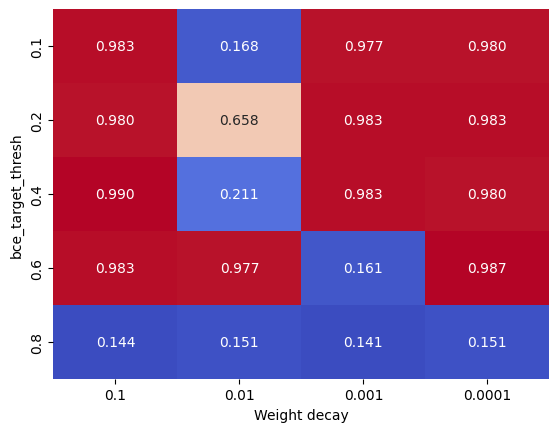

In [21]:
# create the heatmap
sns.heatmap(df, annot=True, fmt=".3f", cmap='coolwarm', cbar=False)

# set the axis labels
plt.xlabel('Weight decay')
plt.ylabel('bce_target_thresh')

# show the plot
plt.show()

## Train sur 100% des données

In [14]:
train_path ="./data/train"
val_path = "./data/val"
num_classes = 120
smoothing=0.1
lr=0.0001
mixup=0.2
batch_size=32
bce_target_thresh=0.4
decay=0.1
num_epochs=10

# Create training and validation datasets
train_dataset, eval_dataset = create_datasets(
        train_path=train_path,
        val_path=val_path,
        image_size=image_size,
        data_mean=data_mean,
        data_std=data_std,
)

mixup_args = dict(
        mixup_alpha=mixup,
        cutmix_alpha=cutmix,
        label_smoothing=smoothing,
        num_classes=num_classes,
)

# Create model using timm
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)



In [15]:
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="AdamW", lr=lr, weight_decay=decay
)
# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
# Create trainer and start training
trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        
        callbacks=[
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
    ],
)

trainer.train(
    per_device_batch_size=batch_size,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    num_epochs=num_epochs,
    create_scheduler_fn=trainer.create_scheduler,
)


Starting training run

Starting epoch 1


100%|██████████| 480/480 [06:13<00:00,  1.29it/s]



train_loss_epoch: 0.05182160064578056


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 4.099597930908203

ema_model_accuracy: 0.010220376774668694

accuracy: 0.08208239823579788

Starting epoch 2


100%|██████████| 480/480 [06:14<00:00,  1.28it/s]



train_loss_epoch: 0.040557097643613815


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 1.5673084259033203

ema_model_accuracy: 0.013094858266413212

accuracy: 0.5576493144035339

Starting epoch 3


100%|██████████| 480/480 [06:14<00:00,  1.28it/s]



train_loss_epoch: 0.03037372976541519


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 1.0921080112457275

ema_model_accuracy: 0.04663046821951866

accuracy: 0.6809325814247131

Starting epoch 4


100%|██████████| 480/480 [06:15<00:00,  1.28it/s]



train_loss_epoch: 0.024676118046045303


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 0.8484959006309509

ema_model_accuracy: 0.09773235023021698

accuracy: 0.7371447086334229

Starting epoch 5


100%|██████████| 480/480 [06:14<00:00,  1.28it/s]



train_loss_epoch: 0.023276520892977715


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 0.7269747257232666

ema_model_accuracy: 0.27850526571273804

accuracy: 0.785691499710083

Starting epoch 6


100%|██████████| 480/480 [06:14<00:00,  1.28it/s]



train_loss_epoch: 0.01971650868654251


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



eval_loss_epoch: 0.6750336289405823

ema_model_accuracy: 0.5100606679916382

accuracy: 0.7981475591659546

Starting epoch 7


100%|██████████| 480/480 [06:23<00:00,  1.25it/s]



train_loss_epoch: 0.018207520246505737


100%|██████████| 98/98 [01:19<00:00,  1.24it/s]



eval_loss_epoch: 0.5779435634613037

ema_model_accuracy: 0.6550622582435608

accuracy: 0.8300862312316895

Starting epoch 8


100%|██████████| 480/480 [05:57<00:00,  1.34it/s]



train_loss_epoch: 0.01669462025165558


100%|██████████| 98/98 [01:51<00:00,  1.14s/it]



eval_loss_epoch: 0.557127058506012

ema_model_accuracy: 0.7256467342376709

accuracy: 0.8380709290504456

Starting epoch 9


100%|██████████| 480/480 [07:11<00:00,  1.11it/s]



train_loss_epoch: 0.015205489471554756


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



eval_loss_epoch: 0.5351110100746155

ema_model_accuracy: 0.7703608870506287

accuracy: 0.8412647843360901

Starting epoch 10


100%|██████████| 480/480 [08:29<00:00,  1.06s/it]



train_loss_epoch: 0.01452785637229681


100%|██████████| 98/98 [01:32<00:00,  1.06it/s]



eval_loss_epoch: 0.525689959526062

ema_model_accuracy: 0.7955924868583679

accuracy: 0.8438198566436768
Finishing training run
Loading checkpoint with accuracy: 0.8438198566436768 from epoch 10
